In [1]:
import sys
sys.path.append('../core')
sys.path.append('/packing/code/core/')

import pack_runner
import pack_ga3
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
import os
import itertools
import glob
import dill
import importlib
from multiprocess import Process, Queue, cpu_count
import kaggle_support as kgs
importlib.reload(pack_runner)

# Configuration
output_dir = '../../results/many_ga/'
os.makedirs(output_dir + 'full/', exist_ok=True)
os.makedirs(output_dir + 'abbr/', exist_ok=True)

fast_mode = True  # Set to True for quick testing
which_runner = pack_runner.baseline_runner  # Which example runner to use
n_parallel_processes = 2 if kgs.env=='local' else 4
print(f"Will use {n_parallel_processes} parallel processes")

local
Will use 2 parallel processes


In [2]:
#test
if fast_mode:
    rr = pack_runner.baseline_runner(fast_mode = fast_mode)
    rr.base_ga.ga.ga_base.N_trees_to_do = 40
    rr.seed=1
    rr.run()

{'seed': 1, 'reset_approach': 2, 'reset_check_generations': 100, 'diversity_reset_threshold': -1.0, 'scale_rough_iterations': 2.0, 'scale_fine_iterations': 1.0, 'connectivity_pattern': 1, 'allow_reset_based_on_local_champion': False, 'prob_mate_own': 0.7, 'JiggleMaxTrees': 5, 'MoveRandomTree': True, 'JiggleTreeSmall': False, 'JiggleTreeBig': True, 'JiggleClusterSmall': True, 'JiggleClusterBig': False, 'Twist': True}
init CUDA
Detected GPU compute capability: 8.9 (arch=sm_89)
GPU max threads per block: 1024
=== Compiling kernel variant: crystal ===
Defines: ENABLE_CRYSTAL_AXES, ENABLE_OVERLAP_AREA, ENABLE_SEPARATION
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_89 -DENABLE_CRYSTAL_AXES -DENABLE_OVERLAP_AREA -DENABLE_SEPARATION -cubin /mnt/d//packing/temp/pack_cuda_saved.cu -o /mnt/d//packing/temp/pack_cuda_crystal.cubin
ptxas info    : 0 bytes gmem, 1172 bytes cmem[3]
ptxas info    : Compiling entry functio

/mnt/d/packing/code/analysis/../core/pack_dynamics.py:61: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/mnt/d/packing/code/analysis/../core/pack_dynamics.py:93: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_cost[:N].toDlpack()), from_dlpack(res.toDlpack())


init LAP CUDA
Detected GPU compute capability: 8.9 (arch=sm_89)
GPU max threads per block: 1024
=== Compiling LAP kernels ===
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_89 -cubin /mnt/d//packing/temp/lap_batch_saved.cu -o /mnt/d//packing/temp/lap_batch.cubin
ptxas info    : 0 bytes gmem
ptxas info    : Compiling entry function 'diversity_shortcut_kernel' for 'sm_89'
ptxas info    : Function properties for diversity_shortcut_kernel
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 29 registers, used 1 barriers, 400 bytes cmem[0]
ptxas info    : Compile time = 9.455 ms
ptxas info    : Compiling entry function 'compute_costs' for 'sm_89'
ptxas info    : Function properties for compute_costs
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 29 registers, used 0 barriers, 384 bytes cmem[0]
ptxas info    : Compile time = 3.013 ms
ptxa

In [3]:
# Get git commit ID for tracking
try:
    import git
    repo = git.Repo(search_parent_directories=True)
    git_commit_id = repo.head.object.hexsha
    print(f"Git commit: {git_commit_id[:8]}")
except:
    git_commit_id = 'no_git'
    print("Git not available, using 'no_git' as commit ID")

Git commit: bced8f09


In [4]:
%load_ext pyinstrument

Detected 1 GPU(s)
Starting parallel execution of 30 seeds using 2 processes
Staggering process startup by 2 seconds each...

Starting process for seed 0...
local
Starting process for seed 1...

All initial processes started. Monitoring for completion...

local
Seed 0 using GPU 0

=== Starting seed 0 (Process 152687) ===
{'seed': 0, 'reset_approach': 4, 'reset_check_generations': 100, 'diversity_reset_threshold': -1.0, 'scale_rough_iterations': 1.0, 'scale_fine_iterations': 1.0, 'connectivity_pattern': 1, 'allow_reset_based_on_local_champion': True, 'prob_mate_own': 0.3, 'JiggleMaxTrees': 5, 'MoveRandomTree': False, 'JiggleTreeSmall': False, 'JiggleTreeBig': False, 'JiggleClusterSmall': False, 'JiggleClusterBig': False, 'Twist': False}
init CUDA
Detected GPU compute capability: 8.9 (arch=sm_89)
GPU max threads per block: 1024
=== Compiling kernel variant: crystal ===
Defines: ENABLE_CRYSTAL_AXES, ENABLE_OVERLAP_AREA, ENABLE_SEPARATION
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math

/mnt/d/packing/code/analysis/../core/pack_dynamics.py:61: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/mnt/d/packing/code/analysis/../core/pack_dynamics.py:93: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_cost[:N].toDlpack()), from_dlpack(res.toDlpack())


Successfully loaded cached lookup table
Compiling CUDA LUT kernel one-time only)
Detected GPU compute capability: 89 (arch=sm_89)
Compiling: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -lineinfo -arch=sm_89 -cubin /mnt/d//packing/temp/pack_cuda_lut_saved.cu -o /mnt/d//packing/temp/pack_cuda_lut.cubin
/mnt/d//packing/temp/pack_cuda_lut_saved.cu:5: warning: "M_PI" redefined
    5 | #define M_PI 3.14159265358979323846f
      | 
In file included from /usr/include/c++/13/cmath:47,
                 from /usr/include/c++/13/math.h:36,
                 from /usr/local/cuda/bin/../targets/x86_64-linux/include/crt/math_functions.h:4577,
                 from /usr/local/cuda/bin/../targets/x86_64-linux/include/crt/common_functions.h:303,
                 from /usr/local/cuda/bin/../targets/x86_64-linux/include/cuda_runtime.h:117,
                 from <command-line>:
/usr/include/math.h:1152: note: this is the location of the previo

/mnt/d/packing/code/analysis/../core/pack_dynamics.py:61: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/mnt/d/packing/code/analysis/../core/pack_dynamics.py:93: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_cost[:N].toDlpack()), from_dlpack(res.toDlpack())


Generation 1: Best costs = [[0.37, 0.064442]]
Runtime: 33.8s

Seed 0 completed in 33.9s
Best final costs: [0.37]
Modifier values: {'seed': 0, 'reset_approach': 4, 'reset_check_generations': 100, 'diversity_reset_threshold': -1.0, 'scale_rough_iterations': 1.0, 'scale_fine_iterations': 1.0, 'connectivity_pattern': 1, 'allow_reset_based_on_local_champion': True, 'prob_mate_own': 0.3, 'JiggleMaxTrees': 5, 'MoveRandomTree': False, 'JiggleTreeSmall': False, 'JiggleTreeBig': False, 'JiggleClusterSmall': False, 'JiggleClusterBig': False, 'Twist': False}
Saved full: ../../results/many_ga/full/Baseline_0_bced8f09_fast_f.pkl
Saved abbr: ../../results/many_ga/abbr/Baseline_0_bced8f09_fast_a.pkl
Seed 0 finished successfully!

*** Result received for seed 0: avg_cost = 0.370000, time = 33.9s ***



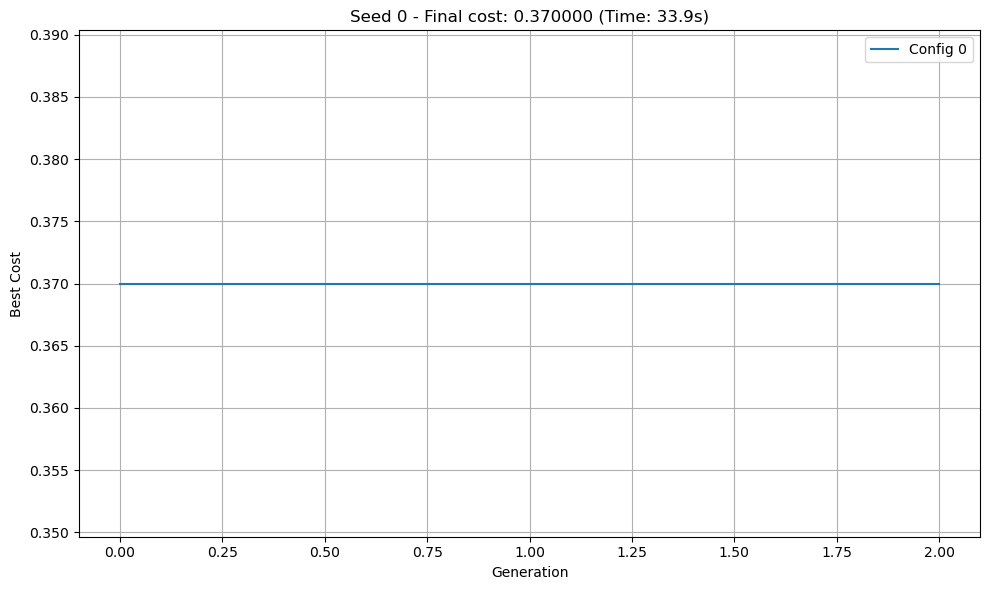

init LAP CUDA
Detected GPU compute capability: 8.9 (arch=sm_89)
GPU max threads per block: 1024
=== Compiling LAP kernels ===
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_89 -cubin /mnt/d//packing/temp/lap_batch_saved.cu -o /mnt/d//packing/temp/lap_batch.cubin
ptxas info    : 0 bytes gmem
ptxas info    : Compiling entry function 'diversity_shortcut_kernel' for 'sm_89'
ptxas info    : Function properties for diversity_shortcut_kernel
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 29 registers, used 1 barriers, 400 bytes cmem[0]
ptxas info    : Compile time = 9.251 ms
ptxas info    : Compiling entry function 'compute_costs' for 'sm_89'
ptxas info    : Function properties for compute_costs
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 29 registers, used 0 barriers, 384 bytes cmem[0]
ptxas info    : Compile time = 3.113 ms
ptxa

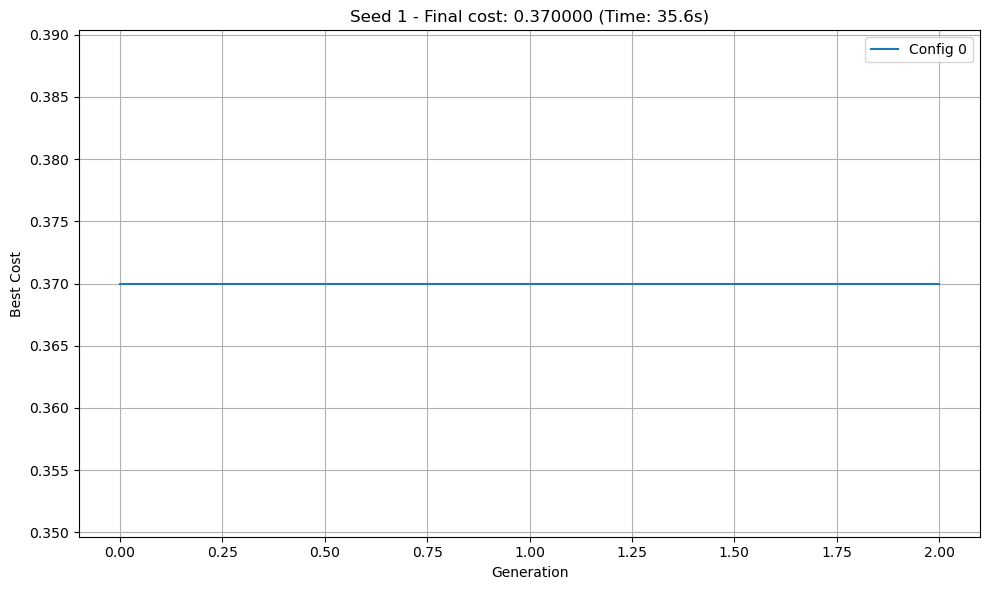

Starting process for seed 3...
local
Seed 2 using GPU 0

=== Starting seed 2 (Process 152996) ===
{'seed': 2, 'reset_approach': 4, 'reset_check_generations': 50, 'diversity_reset_threshold': 0.00025, 'scale_rough_iterations': 1.0, 'scale_fine_iterations': 1.0, 'connectivity_pattern': 5, 'allow_reset_based_on_local_champion': True, 'prob_mate_own': 0.3, 'JiggleMaxTrees': 10, 'MoveRandomTree': False, 'JiggleTreeSmall': False, 'JiggleTreeBig': False, 'JiggleClusterSmall': False, 'JiggleClusterBig': True, 'Twist': False}
init CUDA
Detected GPU compute capability: 8.9 (arch=sm_89)
GPU max threads per block: 1024
=== Compiling kernel variant: crystal ===
Defines: ENABLE_CRYSTAL_AXES, ENABLE_OVERLAP_AREA, ENABLE_SEPARATION
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_89 -DENABLE_CRYSTAL_AXES -DENABLE_OVERLAP_AREA -DENABLE_SEPARATION -cubin /mnt/d//packing/temp/pack_cuda_saved.cu -o /mnt/d//packing/temp/pack_cuda

/mnt/d/packing/code/analysis/../core/pack_dynamics.py:61: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/mnt/d/packing/code/analysis/../core/pack_dynamics.py:93: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_cost[:N].toDlpack()), from_dlpack(res.toDlpack())


Successfully loaded cached lookup table
Compiling CUDA LUT kernel one-time only)
Detected GPU compute capability: 89 (arch=sm_89)
Compiling: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -lineinfo -arch=sm_89 -cubin /mnt/d//packing/temp/pack_cuda_lut_saved.cu -o /mnt/d//packing/temp/pack_cuda_lut.cubin
init LAP CUDA
Detected GPU compute capability: 8.9 (arch=sm_89)
GPU max threads per block: 1024
=== Compiling LAP kernels ===
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_89 -cubin /mnt/d//packing/temp/lap_batch_saved.cu -o /mnt/d//packing/temp/lap_batch.cubin
/mnt/d//packing/temp/pack_cuda_lut_saved.cu:5: warning: "M_PI" redefined
    5 | #define M_PI 3.14159265358979323846f
      | 
In file included from /usr/include/c++/13/cmath:47,
                 from /usr/include/c++/13/math.h:36,
                 from /usr/local/cuda/bin/../targets/x86_6

/mnt/d/packing/code/analysis/../core/pack_dynamics.py:61: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/mnt/d/packing/code/analysis/../core/pack_dynamics.py:93: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_cost[:N].toDlpack()), from_dlpack(res.toDlpack())


Generation 1: Best costs = [[0.37, 0.056173]]
Runtime: 35.5s
init LAP CUDA
Detected GPU compute capability: 8.9 (arch=sm_89)
GPU max threads per block: 1024
=== Compiling LAP kernels ===
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_89 -cubin /mnt/d//packing/temp/lap_batch_saved.cu -o /mnt/d//packing/temp/lap_batch.cubin

Seed 2 completed in 35.7s
Best final costs: [0.37]
Modifier values: {'seed': 2, 'reset_approach': 4, 'reset_check_generations': 50, 'diversity_reset_threshold': 0.00025, 'scale_rough_iterations': 1.0, 'scale_fine_iterations': 1.0, 'connectivity_pattern': 5, 'allow_reset_based_on_local_champion': True, 'prob_mate_own': 0.3, 'JiggleMaxTrees': 10, 'MoveRandomTree': False, 'JiggleTreeSmall': False, 'JiggleTreeBig': False, 'JiggleClusterSmall': False, 'JiggleClusterBig': True, 'Twist': False}
Saved full: ../../results/many_ga/full/Baseline_2_bced8f09_fast_f.pkl
ptxas info    : 0 bytes gmem
ptx

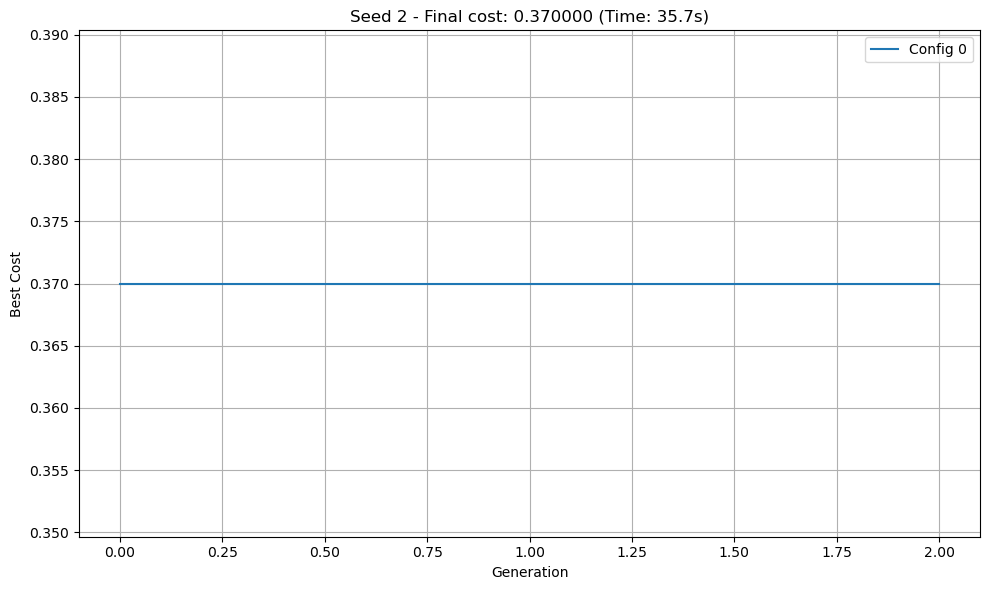

Generation 0: Best costs = [[0.37, 0.13925]]
Starting process for seed 4...
Generation 1: Best costs = [[0.37, 0.052537]]
Runtime: 35.0s

Seed 3 completed in 35.1s
Best final costs: [0.37]
Modifier values: {'seed': 3, 'reset_approach': 4, 'reset_check_generations': 50, 'diversity_reset_threshold': 0.00025, 'scale_rough_iterations': 1.0, 'scale_fine_iterations': 1.0, 'connectivity_pattern': 5, 'allow_reset_based_on_local_champion': False, 'prob_mate_own': 0.7, 'JiggleMaxTrees': 5, 'MoveRandomTree': True, 'JiggleTreeSmall': True, 'JiggleTreeBig': True, 'JiggleClusterSmall': False, 'JiggleClusterBig': True, 'Twist': True}
Saved full: ../../results/many_ga/full/Baseline_3_bced8f09_fast_f.pkl
Saved abbr: ../../results/many_ga/abbr/Baseline_3_bced8f09_fast_a.pkl
Seed 3 finished successfully!

*** Result received for seed 3: avg_cost = 0.370000, time = 35.1s ***



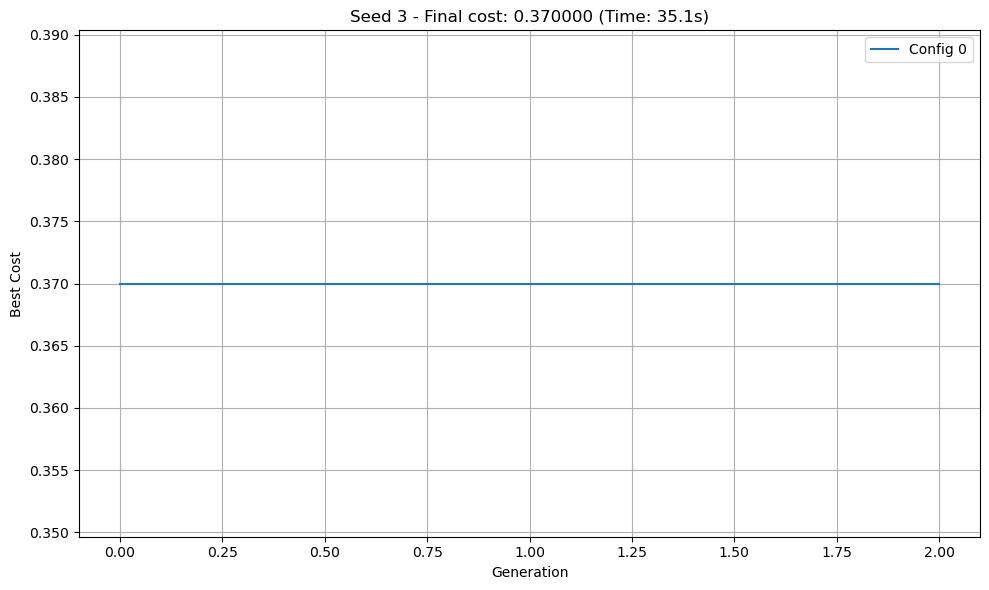

local
Waiting 1.8s before starting seed 5...
Starting process for seed 5...
local
Seed 4 using GPU 0

=== Starting seed 4 (Process 153299) ===
{'seed': 4, 'reset_approach': 3, 'reset_check_generations': 100, 'diversity_reset_threshold': -1.0, 'scale_rough_iterations': 2.0, 'scale_fine_iterations': 2.0, 'connectivity_pattern': 6, 'allow_reset_based_on_local_champion': False, 'prob_mate_own': 0.3, 'JiggleMaxTrees': 10, 'MoveRandomTree': False, 'JiggleTreeSmall': True, 'JiggleTreeBig': True, 'JiggleClusterSmall': False, 'JiggleClusterBig': False, 'Twist': False}
init CUDA
Detected GPU compute capability: 8.9 (arch=sm_89)
GPU max threads per block: 1024
=== Compiling kernel variant: crystal ===
Defines: ENABLE_CRYSTAL_AXES, ENABLE_OVERLAP_AREA, ENABLE_SEPARATION
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_89 -DENABLE_CRYSTAL_AXES -DENABLE_OVERLAP_AREA -DENABLE_SEPARATION -cubin /mnt/d//packing/temp/pack_cuda

/mnt/d/packing/code/analysis/../core/pack_dynamics.py:61: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/mnt/d/packing/code/analysis/../core/pack_dynamics.py:93: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_cost[:N].toDlpack()), from_dlpack(res.toDlpack())
/mnt/d/packing/code/analysis/../core/pack_dynamics.py:61: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/mnt/d/packing/code/analysis/../core/pack_dynamics.py:93: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_

init LAP CUDA
Detected GPU compute capability: 8.9 (arch=sm_89)
GPU max threads per block: 1024
=== Compiling LAP kernels ===
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_89 -cubin /mnt/d//packing/temp/lap_batch_saved.cu -o /mnt/d//packing/temp/lap_batch.cubin
ptxas info    : 0 bytes gmem
ptxas info    : Compiling entry function 'diversity_shortcut_kernel' for 'sm_89'
ptxas info    : Function properties for diversity_shortcut_kernel
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 29 registers, used 1 barriers, 400 bytes cmem[0]
ptxas info    : Compile time = 8.961 ms
ptxas info    : Compiling entry function 'compute_costs' for 'sm_89'
ptxas info    : Function properties for compute_costs
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 29 registers, used 0 barriers, 384 bytes cmem[0]
ptxas info    : Compile time = 2.969 ms
ptxa

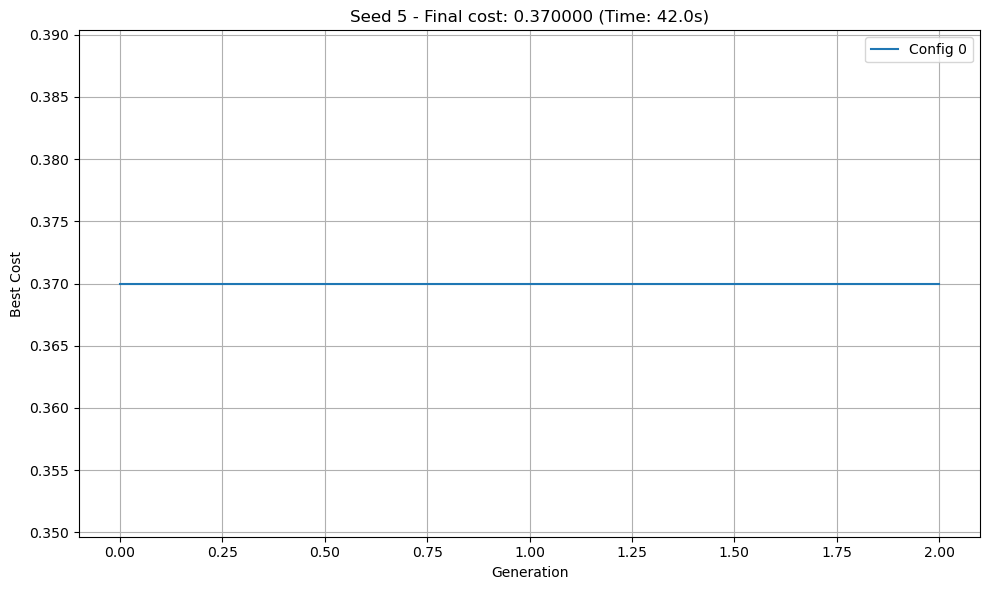

Generation 1: Best costs = [[0.37, 0.0423]]
Runtime: 47.2s

Seed 4 completed in 47.2s
Best final costs: [0.37]
Modifier values: {'seed': 4, 'reset_approach': 3, 'reset_check_generations': 100, 'diversity_reset_threshold': -1.0, 'scale_rough_iterations': 2.0, 'scale_fine_iterations': 2.0, 'connectivity_pattern': 6, 'allow_reset_based_on_local_champion': False, 'prob_mate_own': 0.3, 'JiggleMaxTrees': 10, 'MoveRandomTree': False, 'JiggleTreeSmall': True, 'JiggleTreeBig': True, 'JiggleClusterSmall': False, 'JiggleClusterBig': False, 'Twist': False}
Saved full: ../../results/many_ga/full/Baseline_4_bced8f09_fast_f.pkl
Saved abbr: ../../results/many_ga/abbr/Baseline_4_bced8f09_fast_a.pkl
Seed 4 finished successfully!

*** Result received for seed 4: avg_cost = 0.370000, time = 47.2s ***



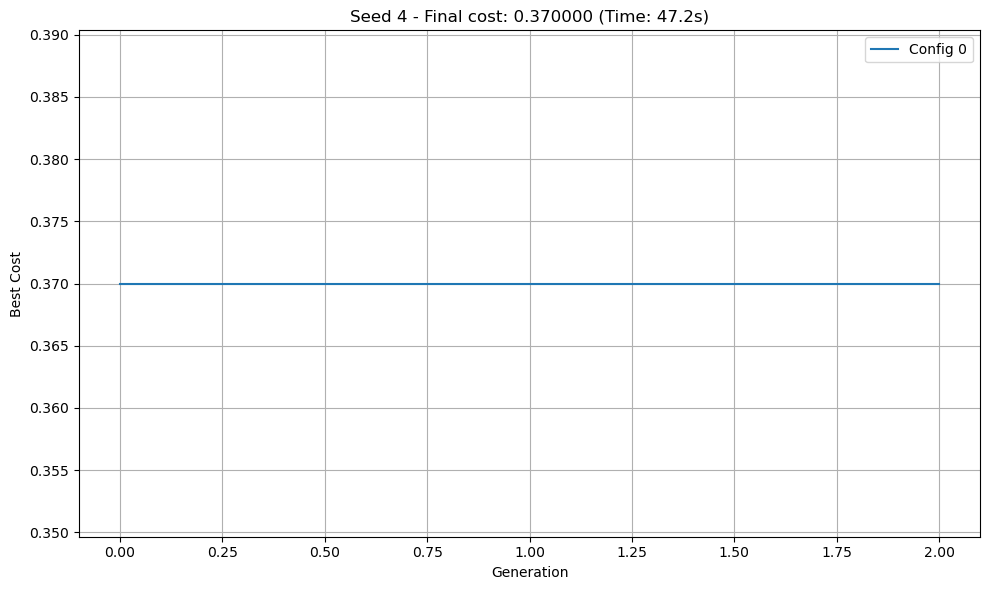

Starting process for seed 6...
Waiting 4.1s before starting seed 7...
local
Starting process for seed 7...
local
Seed 6 using GPU 0

=== Starting seed 6 (Process 153626) ===
{'seed': 6, 'reset_approach': 2, 'reset_check_generations': 100, 'diversity_reset_threshold': -1.0, 'scale_rough_iterations': 1.0, 'scale_fine_iterations': 2.0, 'connectivity_pattern': 3, 'allow_reset_based_on_local_champion': False, 'prob_mate_own': 0.3, 'JiggleMaxTrees': 10, 'MoveRandomTree': False, 'JiggleTreeSmall': True, 'JiggleTreeBig': False, 'JiggleClusterSmall': True, 'JiggleClusterBig': False, 'Twist': False}
init CUDA
Detected GPU compute capability: 8.9 (arch=sm_89)
GPU max threads per block: 1024
=== Compiling kernel variant: crystal ===
Defines: ENABLE_CRYSTAL_AXES, ENABLE_OVERLAP_AREA, ENABLE_SEPARATION
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_89 -DENABLE_CRYSTAL_AXES -DENABLE_OVERLAP_AREA -DENABLE_SEPARATION -cubin

/mnt/d/packing/code/analysis/../core/pack_dynamics.py:61: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())


/mnt/d//packing/temp/pack_cuda_lut_saved.cu:5: warning: "M_PI" redefined
    5 | #define M_PI 3.14159265358979323846f
      | 
In file included from /usr/include/c++/13/cmath:47,
                 from /usr/include/c++/13/math.h:36,
                 from /usr/local/cuda/bin/../targets/x86_64-linux/include/crt/math_functions.h:4577,
                 from /usr/local/cuda/bin/../targets/x86_64-linux/include/crt/common_functions.h:303,
                 from /usr/local/cuda/bin/../targets/x86_64-linux/include/cuda_runtime.h:117,
                 from <command-line>:
/usr/include/math.h:1152: note: this is the location of the previous definition
 1152 | # define M_PI           3.14159265358979323846  /* pi */
      | 
ptxas info    : 16 bytes gmem, 64 bytes cmem[3], 16 bytes cmem[4]
ptxas info    : Compiling entry function 'multi_overlap_lut_total' for 'sm_89'
ptxas info    : Function properties for multi_overlap_lut_total
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptx

/mnt/d/packing/code/analysis/../core/pack_dynamics.py:93: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_cost[:N].toDlpack()), from_dlpack(res.toDlpack())
/mnt/d/packing/code/analysis/../core/pack_dynamics.py:61: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/mnt/d/packing/code/analysis/../core/pack_dynamics.py:93: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_cost[:N].toDlpack()), from_dlpack(res.toDlpack())


init LAP CUDA
Detected GPU compute capability: 8.9 (arch=sm_89)
GPU max threads per block: 1024
=== Compiling LAP kernels ===
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_89 -cubin /mnt/d//packing/temp/lap_batch_saved.cu -o /mnt/d//packing/temp/lap_batch.cubin
ptxas info    : 0 bytes gmem
ptxas info    : Compiling entry function 'diversity_shortcut_kernel' for 'sm_89'
ptxas info    : Function properties for diversity_shortcut_kernel
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 29 registers, used 1 barriers, 400 bytes cmem[0]
ptxas info    : Compile time = 13.774 ms
ptxas info    : Compiling entry function 'compute_costs' for 'sm_89'
ptxas info    : Function properties for compute_costs
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 29 registers, used 0 barriers, 384 bytes cmem[0]
ptxas info    : Compile time = 6.640 ms
ptx

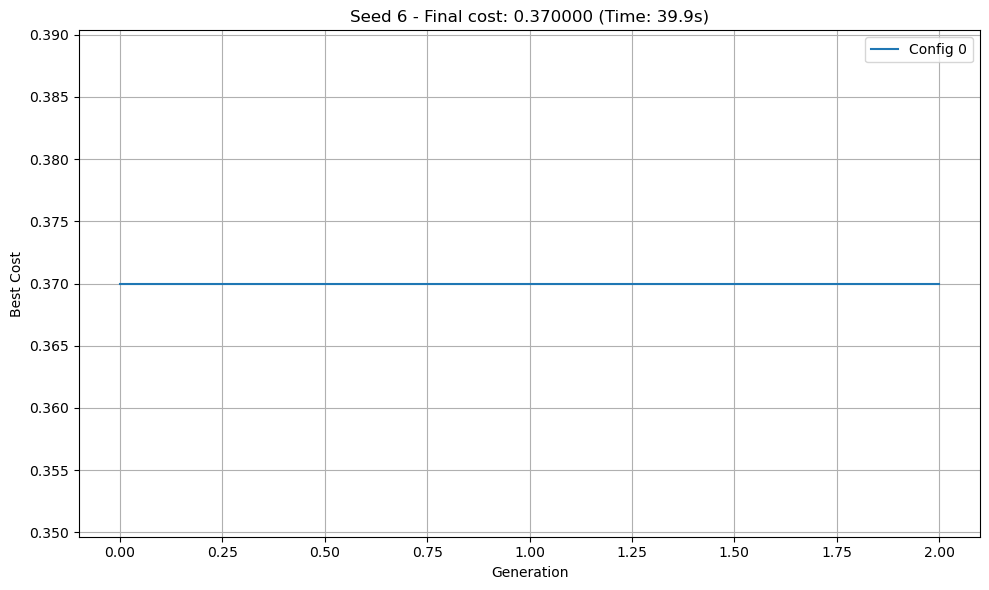

Generation 1: Best costs = [[0.37, 0.040985]]
Runtime: 40.6s

Seed 7 completed in 40.7s
Best final costs: [0.37]
Modifier values: {'seed': 7, 'reset_approach': 4, 'reset_check_generations': 100, 'diversity_reset_threshold': -1.0, 'scale_rough_iterations': 2.0, 'scale_fine_iterations': 2.0, 'connectivity_pattern': 5, 'allow_reset_based_on_local_champion': False, 'prob_mate_own': 0.3, 'JiggleMaxTrees': 5, 'MoveRandomTree': True, 'JiggleTreeSmall': True, 'JiggleTreeBig': False, 'JiggleClusterSmall': False, 'JiggleClusterBig': True, 'Twist': True}
Saved full: ../../results/many_ga/full/Baseline_7_bced8f09_fast_f.pkl
Saved abbr: ../../results/many_ga/abbr/Baseline_7_bced8f09_fast_a.pkl
Seed 7 finished successfully!
Starting process for seed 8...

*** Result received for seed 7: avg_cost = 0.370000, time = 40.7s ***

local


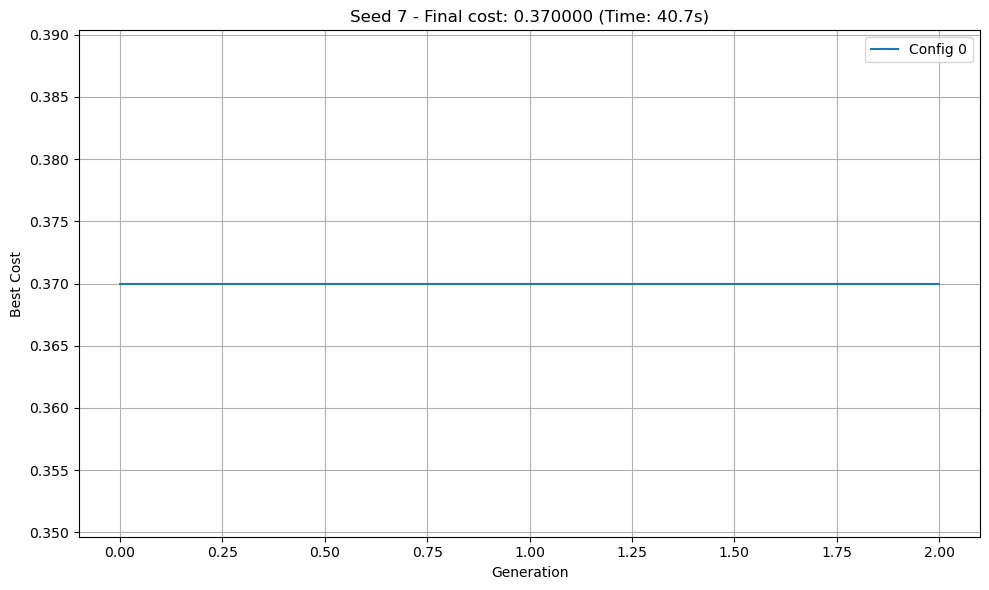

Waiting 1.6s before starting seed 9...
Starting process for seed 9...
local
Seed 8 using GPU 0

=== Starting seed 8 (Process 153934) ===
{'seed': 8, 'reset_approach': 3, 'reset_check_generations': 50, 'diversity_reset_threshold': 0.00025, 'scale_rough_iterations': 2.0, 'scale_fine_iterations': 1.0, 'connectivity_pattern': 2, 'allow_reset_based_on_local_champion': False, 'prob_mate_own': 0.7, 'JiggleMaxTrees': 10, 'MoveRandomTree': False, 'JiggleTreeSmall': True, 'JiggleTreeBig': True, 'JiggleClusterSmall': False, 'JiggleClusterBig': True, 'Twist': True}
init CUDA
Detected GPU compute capability: 8.9 (arch=sm_89)
GPU max threads per block: 1024
=== Compiling kernel variant: crystal ===
Defines: ENABLE_CRYSTAL_AXES, ENABLE_OVERLAP_AREA, ENABLE_SEPARATION
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_89 -DENABLE_CRYSTAL_AXES -DENABLE_OVERLAP_AREA -DENABLE_SEPARATION -cubin /mnt/d//packing/temp/pack_cuda_saved

/mnt/d/packing/code/analysis/../core/pack_dynamics.py:61: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/mnt/d/packing/code/analysis/../core/pack_dynamics.py:93: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_cost[:N].toDlpack()), from_dlpack(res.toDlpack())
/mnt/d/packing/code/analysis/../core/pack_dynamics.py:61: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/mnt/d/packing/code/analysis/../core/pack_dynamics.py:93: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_

init LAP CUDA
Detected GPU compute capability: 8.9 (arch=sm_89)
GPU max threads per block: 1024
=== Compiling LAP kernels ===
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_89 -cubin /mnt/d//packing/temp/lap_batch_saved.cu -o /mnt/d//packing/temp/lap_batch.cubin
ptxas info    : 0 bytes gmem
ptxas info    : Compiling entry function 'diversity_shortcut_kernel' for 'sm_89'
ptxas info    : Function properties for diversity_shortcut_kernel
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 29 registers, used 1 barriers, 400 bytes cmem[0]
ptxas info    : Compile time = 9.470 ms
ptxas info    : Compiling entry function 'compute_costs' for 'sm_89'
ptxas info    : Function properties for compute_costs
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 29 registers, used 0 barriers, 384 bytes cmem[0]
ptxas info    : Compile time = 2.939 ms
ptxa

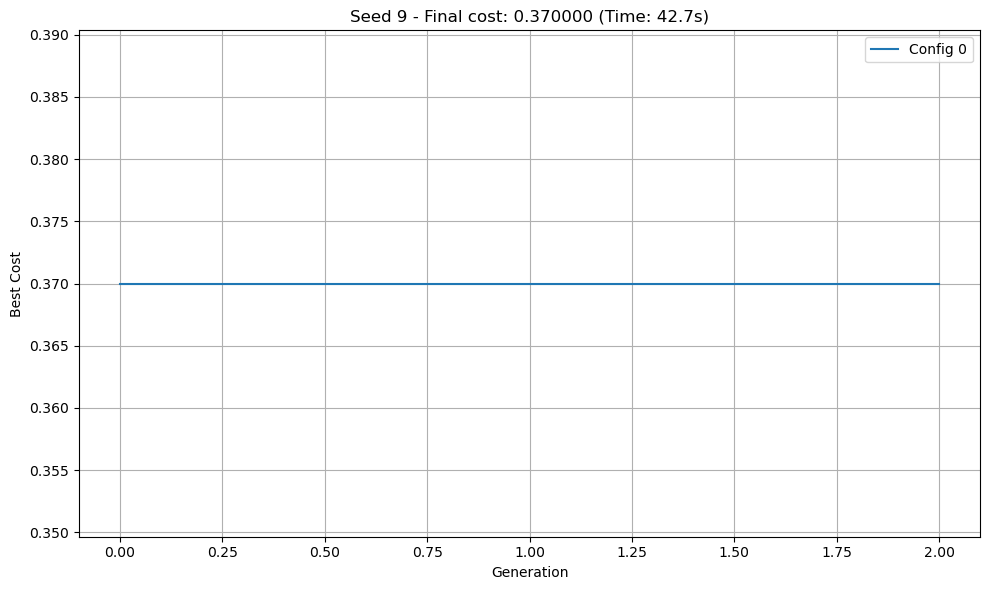

Generation 1: Best costs = [[0.37, 0.021012]]
Runtime: 46.8s

Seed 8 completed in 46.8s
Best final costs: [0.37]
Modifier values: {'seed': 8, 'reset_approach': 3, 'reset_check_generations': 50, 'diversity_reset_threshold': 0.00025, 'scale_rough_iterations': 2.0, 'scale_fine_iterations': 1.0, 'connectivity_pattern': 2, 'allow_reset_based_on_local_champion': False, 'prob_mate_own': 0.7, 'JiggleMaxTrees': 10, 'MoveRandomTree': False, 'JiggleTreeSmall': True, 'JiggleTreeBig': True, 'JiggleClusterSmall': False, 'JiggleClusterBig': True, 'Twist': True}
Saved full: ../../results/many_ga/full/Baseline_8_bced8f09_fast_f.pkl
Saved abbr: ../../results/many_ga/abbr/Baseline_8_bced8f09_fast_a.pkl
Seed 8 finished successfully!

*** Result received for seed 8: avg_cost = 0.370000, time = 46.8s ***



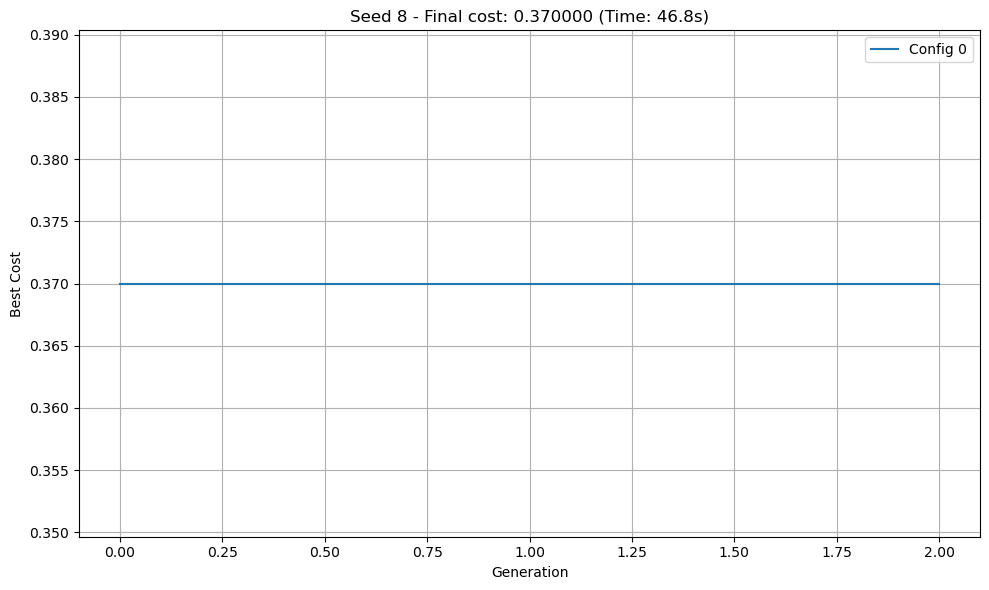

Starting process for seed 10...
Waiting 4.1s before starting seed 11...
local
Starting process for seed 11...
local
Seed 10 using GPU 0

=== Starting seed 10 (Process 154262) ===
{'seed': 10, 'reset_approach': 4, 'reset_check_generations': 100, 'diversity_reset_threshold': 0.00025, 'scale_rough_iterations': 1.0, 'scale_fine_iterations': 2.0, 'connectivity_pattern': 5, 'allow_reset_based_on_local_champion': False, 'prob_mate_own': 0.3, 'JiggleMaxTrees': 20, 'MoveRandomTree': False, 'JiggleTreeSmall': True, 'JiggleTreeBig': True, 'JiggleClusterSmall': True, 'JiggleClusterBig': False, 'Twist': True}
init CUDA
Detected GPU compute capability: 8.9 (arch=sm_89)
GPU max threads per block: 1024
=== Compiling kernel variant: crystal ===
Defines: ENABLE_CRYSTAL_AXES, ENABLE_OVERLAP_AREA, ENABLE_SEPARATION
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_89 -DENABLE_CRYSTAL_AXES -DENABLE_OVERLAP_AREA -DENABLE_SEPARATION

/mnt/d/packing/code/analysis/../core/pack_dynamics.py:61: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/mnt/d/packing/code/analysis/../core/pack_dynamics.py:93: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_cost[:N].toDlpack()), from_dlpack(res.toDlpack())
/mnt/d/packing/code/analysis/../core/pack_dynamics.py:61: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/mnt/d/packing/code/analysis/../core/pack_dynamics.py:93: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_

init LAP CUDA
Detected GPU compute capability: 8.9 (arch=sm_89)
GPU max threads per block: 1024
=== Compiling LAP kernels ===
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_89 -cubin /mnt/d//packing/temp/lap_batch_saved.cu -o /mnt/d//packing/temp/lap_batch.cubin
init LAP CUDA
Detected GPU compute capability: 8.9 (arch=sm_89)
GPU max threads per block: 1024
=== Compiling LAP kernels ===
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_89 -cubin /mnt/d//packing/temp/lap_batch_saved.cu -o /mnt/d//packing/temp/lap_batch.cubin
ptxas info    : 0 bytes gmem
ptxas info    : Compiling entry function 'diversity_shortcut_kernel' for 'sm_89'
ptxas info    : Function properties for diversity_shortcut_kernel
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 29 registers, used 1 barriers, 400 bytes cmem[0]
p

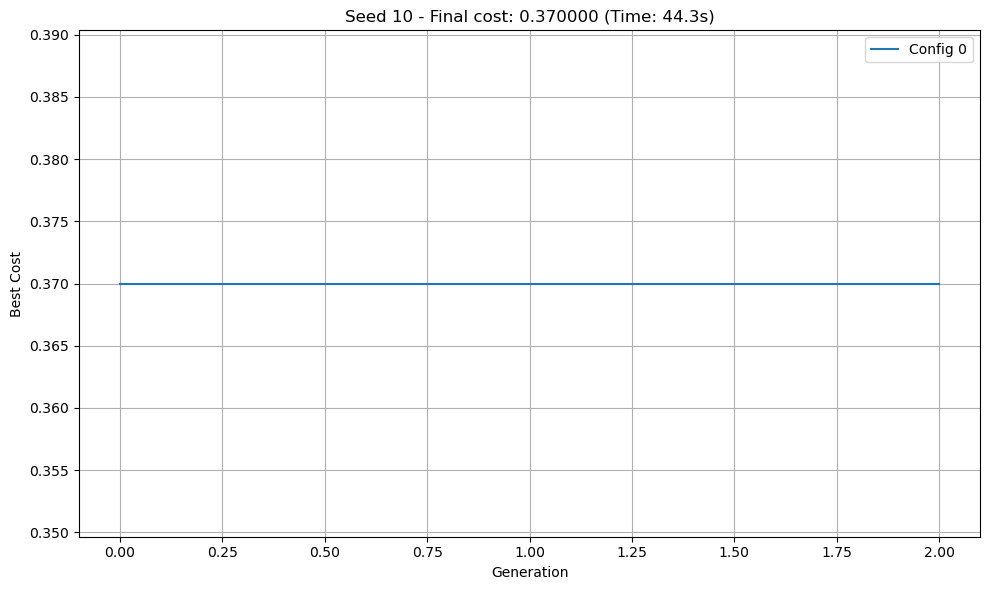


*** Result received for seed 11: avg_cost = 0.370000, time = 41.0s ***



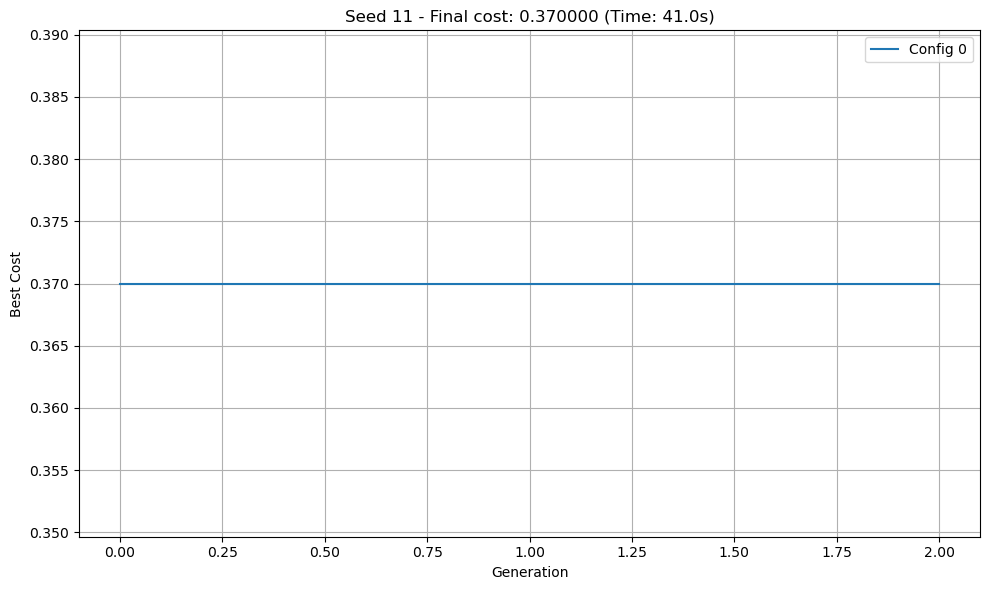

Starting process for seed 12...
Waiting 5.0s before starting seed 13...
local
Starting process for seed 13...
local
Seed 12 using GPU 0

=== Starting seed 12 (Process 154588) ===
{'seed': 12, 'reset_approach': 3, 'reset_check_generations': 50, 'diversity_reset_threshold': -1.0, 'scale_rough_iterations': 2.0, 'scale_fine_iterations': 1.0, 'connectivity_pattern': 2, 'allow_reset_based_on_local_champion': True, 'prob_mate_own': 0.3, 'JiggleMaxTrees': 10, 'MoveRandomTree': True, 'JiggleTreeSmall': True, 'JiggleTreeBig': True, 'JiggleClusterSmall': False, 'JiggleClusterBig': False, 'Twist': False}
init CUDA
Detected GPU compute capability: 8.9 (arch=sm_89)
GPU max threads per block: 1024
=== Compiling kernel variant: crystal ===
Defines: ENABLE_CRYSTAL_AXES, ENABLE_OVERLAP_AREA, ENABLE_SEPARATION
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_89 -DENABLE_CRYSTAL_AXES -DENABLE_OVERLAP_AREA -DENABLE_SEPARATION -cu

/mnt/d/packing/code/analysis/../core/pack_dynamics.py:61: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/mnt/d/packing/code/analysis/../core/pack_dynamics.py:93: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_cost[:N].toDlpack()), from_dlpack(res.toDlpack())


Successfully loaded cached lookup table
Compiling CUDA LUT kernel one-time only)
Detected GPU compute capability: 89 (arch=sm_89)
Compiling: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -lineinfo -arch=sm_89 -cubin /mnt/d//packing/temp/pack_cuda_lut_saved.cu -o /mnt/d//packing/temp/pack_cuda_lut.cubin
/mnt/d//packing/temp/pack_cuda_lut_saved.cu:5: warning: "M_PI" redefined
    5 | #define M_PI 3.14159265358979323846f
      | 
In file included from /usr/include/c++/13/cmath:47,
                 from /usr/include/c++/13/math.h:36,
                 from /usr/local/cuda/bin/../targets/x86_64-linux/include/crt/math_functions.h:4577,
                 from /usr/local/cuda/bin/../targets/x86_64-linux/include/crt/common_functions.h:303,
                 from /usr/local/cuda/bin/../targets/x86_64-linux/include/cuda_runtime.h:117,
                 from <command-line>:
/usr/include/math.h:1152: note: this is the location of the previo

/mnt/d/packing/code/analysis/../core/pack_dynamics.py:61: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/mnt/d/packing/code/analysis/../core/pack_dynamics.py:93: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_cost[:N].toDlpack()), from_dlpack(res.toDlpack())


init LAP CUDA
Detected GPU compute capability: 8.9 (arch=sm_89)
GPU max threads per block: 1024
=== Compiling LAP kernels ===
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_89 -cubin /mnt/d//packing/temp/lap_batch_saved.cu -o /mnt/d//packing/temp/lap_batch.cubin
ptxas info    : 0 bytes gmem
ptxas info    : Compiling entry function 'diversity_shortcut_kernel' for 'sm_89'
ptxas info    : Function properties for diversity_shortcut_kernel
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 29 registers, used 1 barriers, 400 bytes cmem[0]
ptxas info    : Compile time = 9.236 ms
ptxas info    : Compiling entry function 'compute_costs' for 'sm_89'
ptxas info    : Function properties for compute_costs
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 29 registers, used 0 barriers, 384 bytes cmem[0]
ptxas info    : Compile time = 2.982 ms
ptxa

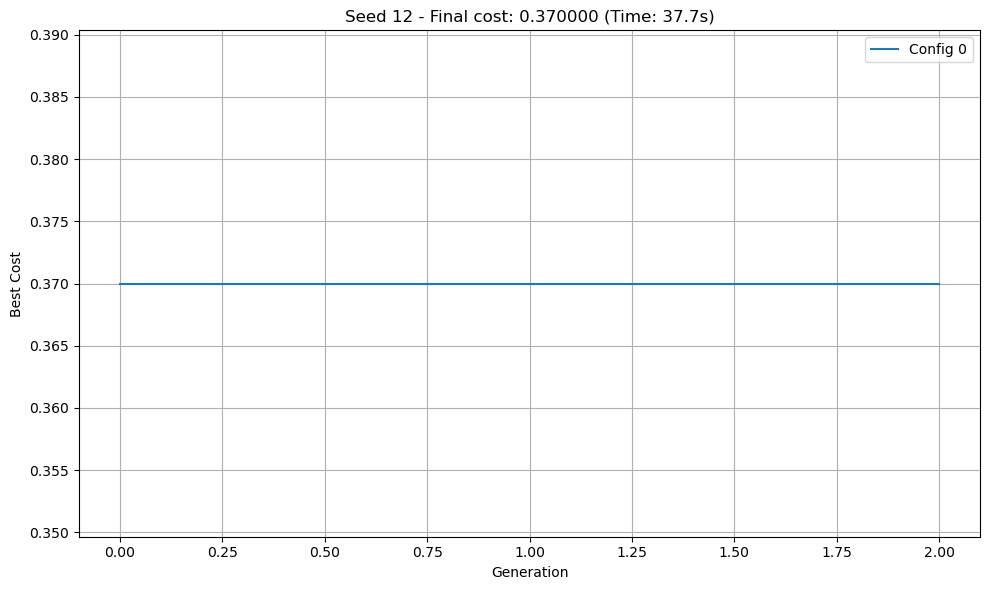

Generation 1: Best costs = [[0.37, 0.037293]]
Runtime: 36.2s

Seed 13 completed in 36.2s
Best final costs: [0.37]
Modifier values: {'seed': 13, 'reset_approach': 4, 'reset_check_generations': 100, 'diversity_reset_threshold': -1.0, 'scale_rough_iterations': 2.0, 'scale_fine_iterations': 1.0, 'connectivity_pattern': 5, 'allow_reset_based_on_local_champion': False, 'prob_mate_own': 0.3, 'JiggleMaxTrees': 5, 'MoveRandomTree': True, 'JiggleTreeSmall': False, 'JiggleTreeBig': False, 'JiggleClusterSmall': False, 'JiggleClusterBig': False, 'Twist': False}
Saved full: ../../results/many_ga/full/Baseline_13_bced8f09_fast_f.pkl
Saved abbr: ../../results/many_ga/abbr/Baseline_13_bced8f09_fast_a.pkl
Seed 13 finished successfully!

*** Result received for seed 13: avg_cost = 0.370000, time = 36.2s ***



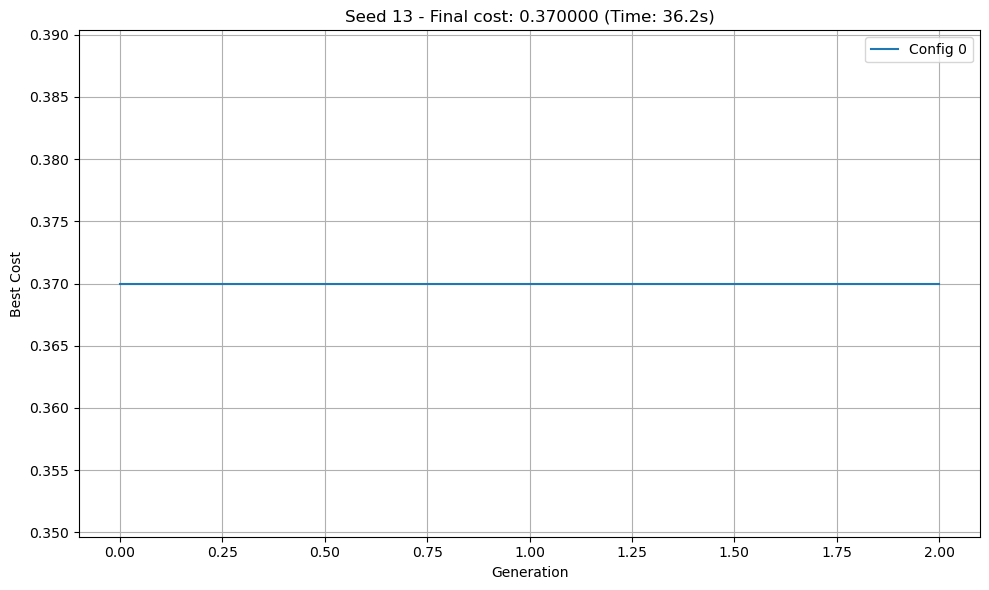

Starting process for seed 14...
Waiting 3.5s before starting seed 15...
local
Starting process for seed 15...
local
Seed 14 using GPU 0

=== Starting seed 14 (Process 154891) ===
{'seed': 14, 'reset_approach': 1, 'reset_check_generations': 100, 'diversity_reset_threshold': -1.0, 'scale_rough_iterations': 1.0, 'scale_fine_iterations': 1.0, 'connectivity_pattern': 5, 'allow_reset_based_on_local_champion': True, 'prob_mate_own': 0.7, 'JiggleMaxTrees': 10, 'MoveRandomTree': False, 'JiggleTreeSmall': True, 'JiggleTreeBig': False, 'JiggleClusterSmall': True, 'JiggleClusterBig': False, 'Twist': True}
init CUDA
Detected GPU compute capability: 8.9 (arch=sm_89)
GPU max threads per block: 1024
=== Compiling kernel variant: crystal ===
Defines: ENABLE_CRYSTAL_AXES, ENABLE_OVERLAP_AREA, ENABLE_SEPARATION
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_89 -DENABLE_CRYSTAL_AXES -DENABLE_OVERLAP_AREA -DENABLE_SEPARATION -c

/mnt/d/packing/code/analysis/../core/pack_dynamics.py:61: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/mnt/d/packing/code/analysis/../core/pack_dynamics.py:61: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/mnt/d/packing/code/analysis/../core/pack_dynamics.py:93: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_cost[:N].toDlpack()), from_dlpack(res.toDlpack())
/mnt/d/packing/code/analysis/../core/pack_dynamics.py:93: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_

init LAP CUDA
Detected GPU compute capability: 8.9 (arch=sm_89)
GPU max threads per block: 1024
=== Compiling LAP kernels ===
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_89 -cubin /mnt/d//packing/temp/lap_batch_saved.cu -o /mnt/d//packing/temp/lap_batch.cubin
ptxas info    : 0 bytes gmem
ptxas info    : Compiling entry function 'diversity_shortcut_kernel' for 'sm_89'
ptxas info    : Function properties for diversity_shortcut_kernel
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 29 registers, used 1 barriers, 400 bytes cmem[0]
ptxas info    : Compile time = 11.999 ms
ptxas info    : Compiling entry function 'compute_costs' for 'sm_89'
ptxas info    : Function properties for compute_costs
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 29 registers, used 0 barriers, 384 bytes cmem[0]
ptxas info    : Compile time = 2.961 ms
ptx

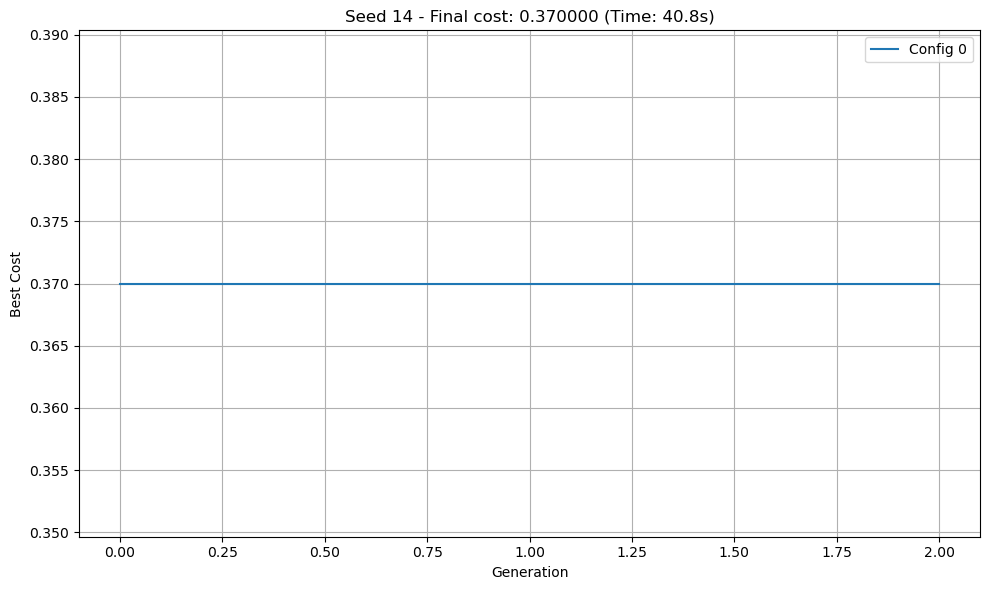

Generation 1: Best costs = [[0.37, 0.05134]]
Runtime: 38.8s

Seed 15 completed in 38.8s
Best final costs: [0.37]
Modifier values: {'seed': 15, 'reset_approach': 4, 'reset_check_generations': 100, 'diversity_reset_threshold': -1.0, 'scale_rough_iterations': 2.0, 'scale_fine_iterations': 1.0, 'connectivity_pattern': 3, 'allow_reset_based_on_local_champion': True, 'prob_mate_own': 0.3, 'JiggleMaxTrees': 10, 'MoveRandomTree': False, 'JiggleTreeSmall': False, 'JiggleTreeBig': True, 'JiggleClusterSmall': False, 'JiggleClusterBig': False, 'Twist': True}
Saved full: ../../results/many_ga/full/Baseline_15_bced8f09_fast_f.pkl
Saved abbr: ../../results/many_ga/abbr/Baseline_15_bced8f09_fast_a.pkl
Seed 15 finished successfully!

*** Result received for seed 15: avg_cost = 0.370000, time = 38.8s ***



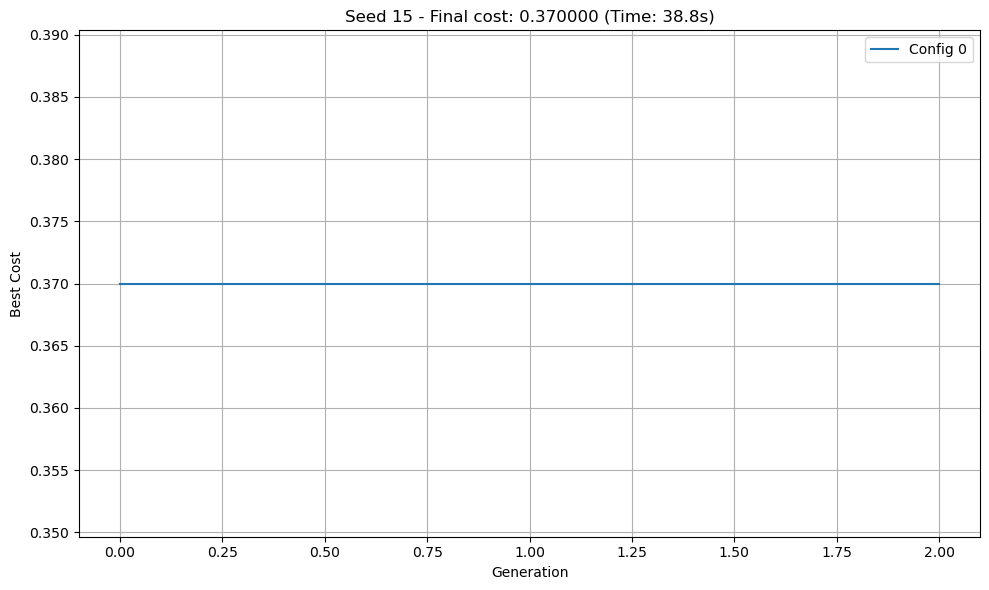

Starting process for seed 16...
Waiting 4.4s before starting seed 17...
local
Starting process for seed 17...
local
Seed 16 using GPU 0

=== Starting seed 16 (Process 155205) ===
{'seed': 16, 'reset_approach': 3, 'reset_check_generations': 100, 'diversity_reset_threshold': -1.0, 'scale_rough_iterations': 1.0, 'scale_fine_iterations': 2.0, 'connectivity_pattern': 1, 'allow_reset_based_on_local_champion': False, 'prob_mate_own': 0.3, 'JiggleMaxTrees': 5, 'MoveRandomTree': False, 'JiggleTreeSmall': True, 'JiggleTreeBig': True, 'JiggleClusterSmall': True, 'JiggleClusterBig': False, 'Twist': True}
init CUDA
Detected GPU compute capability: 8.9 (arch=sm_89)
GPU max threads per block: 1024
=== Compiling kernel variant: crystal ===
Defines: ENABLE_CRYSTAL_AXES, ENABLE_OVERLAP_AREA, ENABLE_SEPARATION
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_89 -DENABLE_CRYSTAL_AXES -DENABLE_OVERLAP_AREA -DENABLE_SEPARATION -cu

/mnt/d/packing/code/analysis/../core/pack_dynamics.py:61: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/mnt/d/packing/code/analysis/../core/pack_dynamics.py:93: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_cost[:N].toDlpack()), from_dlpack(res.toDlpack())


Successfully loaded cached lookup table
Compiling CUDA LUT kernel one-time only)
Detected GPU compute capability: 89 (arch=sm_89)
Compiling: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -lineinfo -arch=sm_89 -cubin /mnt/d//packing/temp/pack_cuda_lut_saved.cu -o /mnt/d//packing/temp/pack_cuda_lut.cubin
init LAP CUDA
Detected GPU compute capability: 8.9 (arch=sm_89)
GPU max threads per block: 1024
=== Compiling LAP kernels ===
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_89 -cubin /mnt/d//packing/temp/lap_batch_saved.cu -o /mnt/d//packing/temp/lap_batch.cubin
/mnt/d//packing/temp/pack_cuda_lut_saved.cu:5: warning: "M_PI" redefined
    5 | #define M_PI 3.14159265358979323846f
      | 
In file included from /usr/include/c++/13/cmath:47,
                 from /usr/include/c++/13/math.h:36,
                 from /usr/local/cuda/bin/../targets/x86_6

/mnt/d/packing/code/analysis/../core/pack_dynamics.py:61: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/mnt/d/packing/code/analysis/../core/pack_dynamics.py:93: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_cost[:N].toDlpack()), from_dlpack(res.toDlpack())


init LAP CUDA
Detected GPU compute capability: 8.9 (arch=sm_89)
GPU max threads per block: 1024
=== Compiling LAP kernels ===
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_89 -cubin /mnt/d//packing/temp/lap_batch_saved.cu -o /mnt/d//packing/temp/lap_batch.cubin
ptxas info    : 0 bytes gmem
ptxas info    : Compiling entry function 'diversity_shortcut_kernel' for 'sm_89'
ptxas info    : Function properties for diversity_shortcut_kernel
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 29 registers, used 1 barriers, 400 bytes cmem[0]
ptxas info    : Compile time = 9.267 ms
ptxas info    : Compiling entry function 'compute_costs' for 'sm_89'
ptxas info    : Function properties for compute_costs
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 29 registers, used 0 barriers, 384 bytes cmem[0]
ptxas info    : Compile time = 2.956 ms
ptxa

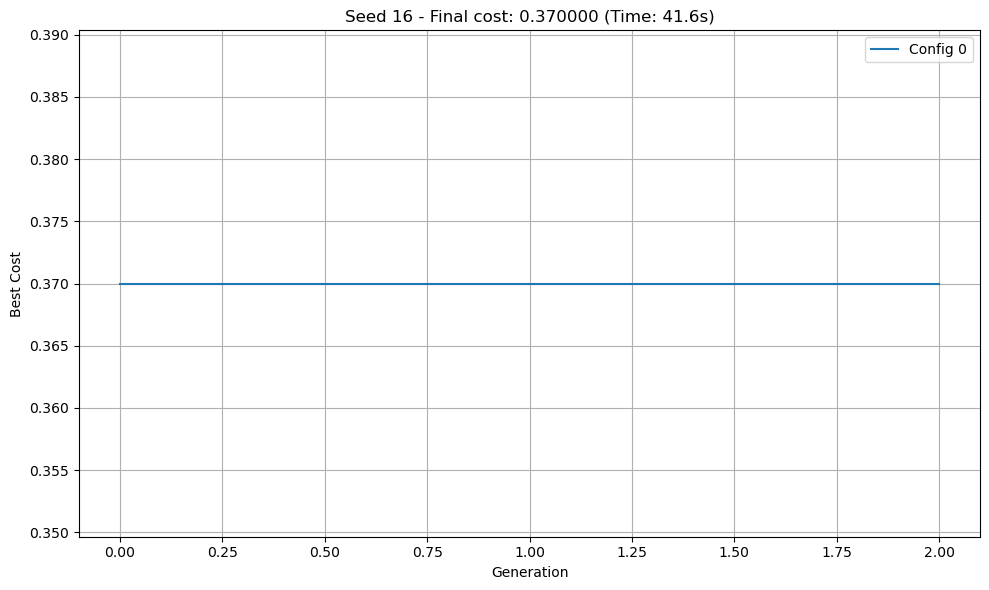

Generation 1: Best costs = [[0.37, 0.050772]]
Runtime: 38.7s

Seed 17 completed in 38.7s
Best final costs: [0.37]
Modifier values: {'seed': 17, 'reset_approach': 3, 'reset_check_generations': 100, 'diversity_reset_threshold': 0.00025, 'scale_rough_iterations': 1.0, 'scale_fine_iterations': 1.0, 'connectivity_pattern': 4, 'allow_reset_based_on_local_champion': False, 'prob_mate_own': 0.3, 'JiggleMaxTrees': 5, 'MoveRandomTree': True, 'JiggleTreeSmall': True, 'JiggleTreeBig': True, 'JiggleClusterSmall': False, 'JiggleClusterBig': True, 'Twist': False}
Starting process for seed 18...
Saved full: ../../results/many_ga/full/Baseline_17_bced8f09_fast_f.pkl
Saved abbr: ../../results/many_ga/abbr/Baseline_17_bced8f09_fast_a.pkl
Seed 17 finished successfully!

*** Result received for seed 17: avg_cost = 0.370000, time = 38.7s ***



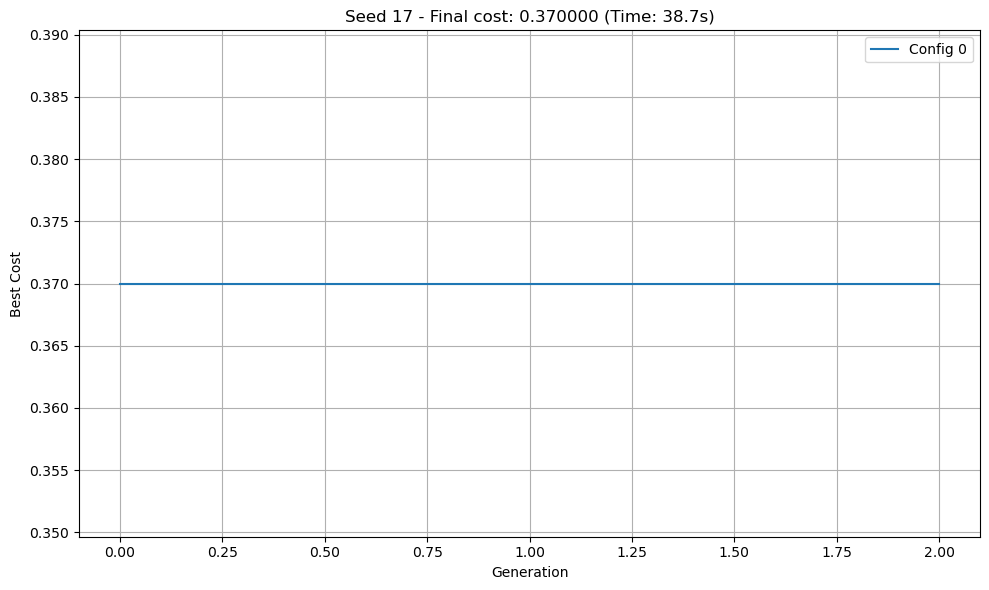

local
Waiting 2.6s before starting seed 19...
Starting process for seed 19...
local
Seed 18 using GPU 0

=== Starting seed 18 (Process 155513) ===
{'seed': 18, 'reset_approach': 4, 'reset_check_generations': 50, 'diversity_reset_threshold': 0.00025, 'scale_rough_iterations': 2.0, 'scale_fine_iterations': 2.0, 'connectivity_pattern': 2, 'allow_reset_based_on_local_champion': True, 'prob_mate_own': 0.3, 'JiggleMaxTrees': 20, 'MoveRandomTree': False, 'JiggleTreeSmall': False, 'JiggleTreeBig': False, 'JiggleClusterSmall': False, 'JiggleClusterBig': False, 'Twist': False}
init CUDA
Detected GPU compute capability: 8.9 (arch=sm_89)
GPU max threads per block: 1024
=== Compiling kernel variant: crystal ===
Defines: ENABLE_CRYSTAL_AXES, ENABLE_OVERLAP_AREA, ENABLE_SEPARATION
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_89 -DENABLE_CRYSTAL_AXES -DENABLE_OVERLAP_AREA -DENABLE_SEPARATION -cubin /mnt/d//packing/temp/p

/mnt/d/packing/code/analysis/../core/pack_dynamics.py:61: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/mnt/d/packing/code/analysis/../core/pack_dynamics.py:93: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_cost[:N].toDlpack()), from_dlpack(res.toDlpack())


Starting process for seed 20...
init LAP CUDA
Detected GPU compute capability: 8.9 (arch=sm_89)
GPU max threads per block: 1024
=== Compiling LAP kernels ===
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_89 -cubin /mnt/d//packing/temp/lap_batch_saved.cu -o /mnt/d//packing/temp/lap_batch.cubin
ptxas info    : 0 bytes gmem
ptxas info    : Compiling entry function 'diversity_shortcut_kernel' for 'sm_89'
ptxas info    : Function properties for diversity_shortcut_kernel
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 29 registers, used 1 barriers, 400 bytes cmem[0]
ptxas info    : Compile time = 10.405 ms
ptxas info    : Compiling entry function 'compute_costs' for 'sm_89'
ptxas info    : Function properties for compute_costs
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 29 registers, used 0 barriers, 384 bytes cmem[0]
ptxas info 

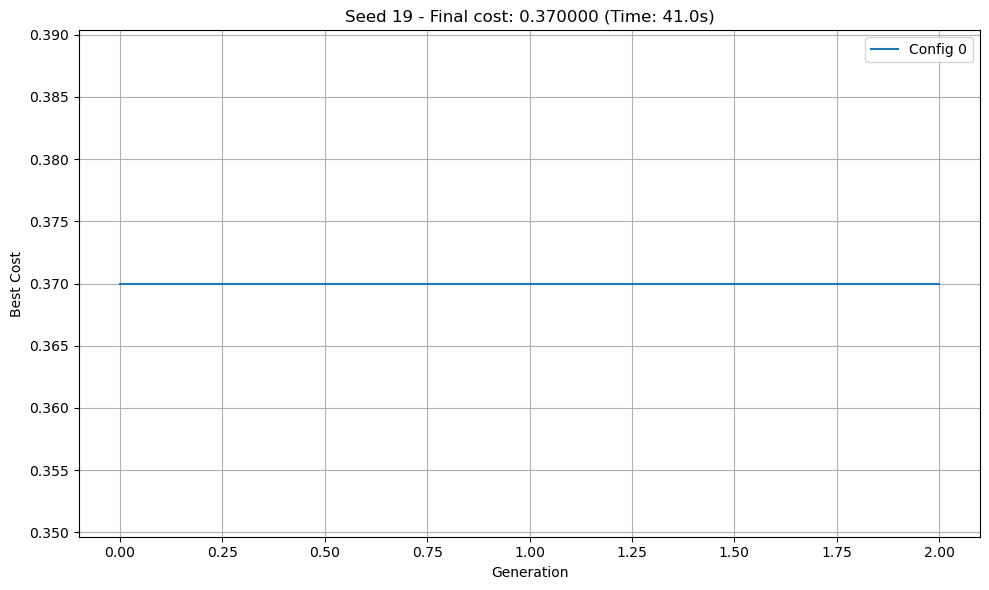

Starting process for seed 21...
local
Seed 20 using GPU 0

=== Starting seed 20 (Process 155783) ===
{'seed': 20, 'reset_approach': 4, 'reset_check_generations': 50, 'diversity_reset_threshold': 0.00025, 'scale_rough_iterations': 1.0, 'scale_fine_iterations': 2.0, 'connectivity_pattern': 1, 'allow_reset_based_on_local_champion': True, 'prob_mate_own': 0.7, 'JiggleMaxTrees': 5, 'MoveRandomTree': True, 'JiggleTreeSmall': True, 'JiggleTreeBig': True, 'JiggleClusterSmall': True, 'JiggleClusterBig': True, 'Twist': False}
init CUDA
Detected GPU compute capability: 8.9 (arch=sm_89)
GPU max threads per block: 1024
=== Compiling kernel variant: crystal ===
Defines: ENABLE_CRYSTAL_AXES, ENABLE_OVERLAP_AREA, ENABLE_SEPARATION
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_89 -DENABLE_CRYSTAL_AXES -DENABLE_OVERLAP_AREA -DENABLE_SEPARATION -cubin /mnt/d//packing/temp/pack_cuda_saved.cu -o /mnt/d//packing/temp/pack_cuda_

/mnt/d/packing/code/analysis/../core/pack_dynamics.py:61: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/mnt/d/packing/code/analysis/../core/pack_dynamics.py:93: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_cost[:N].toDlpack()), from_dlpack(res.toDlpack())


init LAP CUDA
Detected GPU compute capability: 8.9 (arch=sm_89)
GPU max threads per block: 1024
=== Compiling LAP kernels ===
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_89 -cubin /mnt/d//packing/temp/lap_batch_saved.cu -o /mnt/d//packing/temp/lap_batch.cubin
ptxas info    : 0 bytes gmem
ptxas info    : Compiling entry function 'diversity_shortcut_kernel' for 'sm_89'
ptxas info    : Function properties for diversity_shortcut_kernel
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 29 registers, used 1 barriers, 400 bytes cmem[0]
ptxas info    : Compile time = 10.573 ms
ptxas info    : Compiling entry function 'compute_costs' for 'sm_89'
ptxas info    : Function properties for compute_costs
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 29 registers, used 0 barriers, 384 bytes cmem[0]
ptxas info    : Compile time = 3.149 ms
ptx

/mnt/d/packing/code/analysis/../core/pack_dynamics.py:61: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/mnt/d/packing/code/analysis/../core/pack_dynamics.py:93: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_cost[:N].toDlpack()), from_dlpack(res.toDlpack())


Saved full: ../../results/many_ga/full/Baseline_20_bced8f09_fast_f.pkl
Saved abbr: ../../results/many_ga/abbr/Baseline_20_bced8f09_fast_a.pkl
Seed 20 finished successfully!

*** Result received for seed 20: avg_cost = 0.370000, time = 39.5s ***



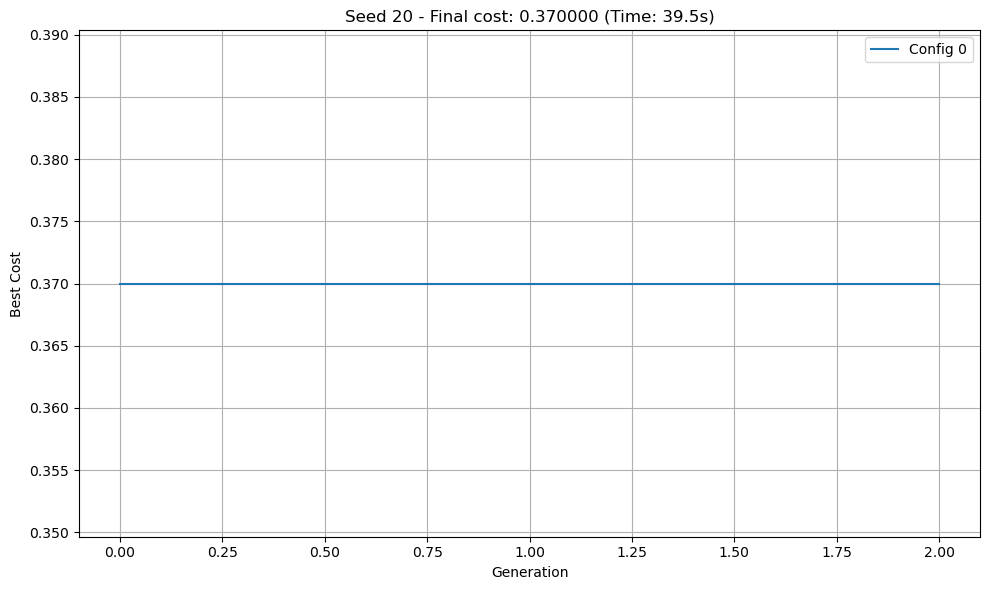

Starting process for seed 22...
local
init LAP CUDA
Detected GPU compute capability: 8.9 (arch=sm_89)
GPU max threads per block: 1024
=== Compiling LAP kernels ===
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_89 -cubin /mnt/d//packing/temp/lap_batch_saved.cu -o /mnt/d//packing/temp/lap_batch.cubin
ptxas info    : 0 bytes gmem
ptxas info    : Compiling entry function 'diversity_shortcut_kernel' for 'sm_89'
ptxas info    : Function properties for diversity_shortcut_kernel
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 29 registers, used 1 barriers, 400 bytes cmem[0]
ptxas info    : Compile time = 17.548 ms
ptxas info    : Compiling entry function 'compute_costs' for 'sm_89'
ptxas info    : Function properties for compute_costs
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 29 registers, used 0 barriers, 384 bytes cmem[0]
ptxas

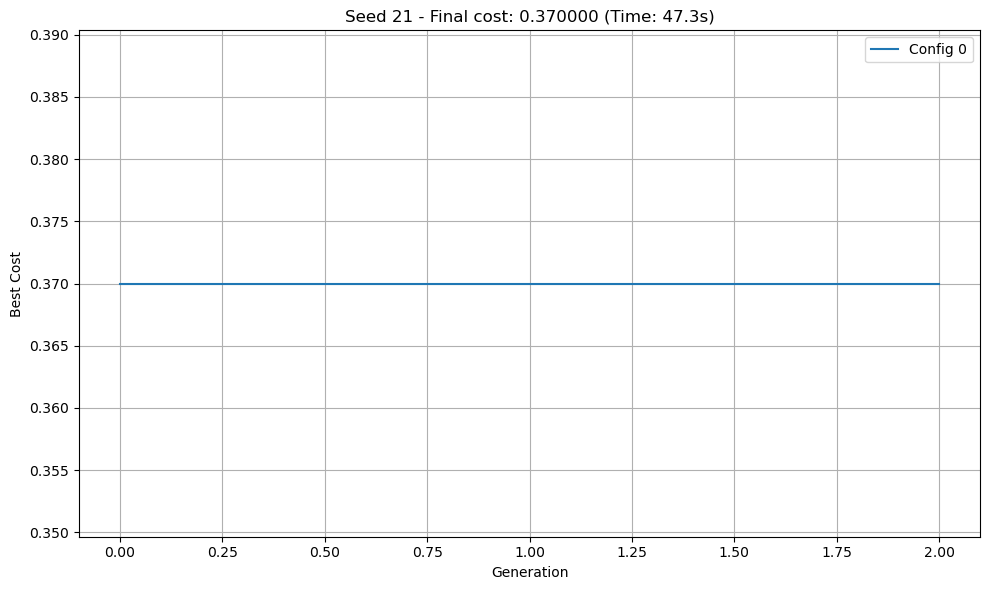

Seed 22 using GPU 0

=== Starting seed 22 (Process 156098) ===
{'seed': 22, 'reset_approach': 4, 'reset_check_generations': 50, 'diversity_reset_threshold': -1.0, 'scale_rough_iterations': 1.0, 'scale_fine_iterations': 2.0, 'connectivity_pattern': 1, 'allow_reset_based_on_local_champion': True, 'prob_mate_own': 0.7, 'JiggleMaxTrees': 5, 'MoveRandomTree': True, 'JiggleTreeSmall': True, 'JiggleTreeBig': False, 'JiggleClusterSmall': True, 'JiggleClusterBig': False, 'Twist': True}
init CUDA
Detected GPU compute capability: 8.9 (arch=sm_89)
GPU max threads per block: 1024
=== Compiling kernel variant: crystal ===
Defines: ENABLE_CRYSTAL_AXES, ENABLE_OVERLAP_AREA, ENABLE_SEPARATION
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_89 -DENABLE_CRYSTAL_AXES -DENABLE_OVERLAP_AREA -DENABLE_SEPARATION -cubin /mnt/d//packing/temp/pack_cuda_saved.cu -o /mnt/d//packing/temp/pack_cuda_crystal.cubin
Starting process for seed 

/mnt/d/packing/code/analysis/../core/pack_dynamics.py:61: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/mnt/d/packing/code/analysis/../core/pack_dynamics.py:93: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_cost[:N].toDlpack()), from_dlpack(res.toDlpack())


init LAP CUDA
Detected GPU compute capability: 8.9 (arch=sm_89)
GPU max threads per block: 1024
=== Compiling LAP kernels ===
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_89 -cubin /mnt/d//packing/temp/lap_batch_saved.cu -o /mnt/d//packing/temp/lap_batch.cubin
ptxas info    : 0 bytes gmem
ptxas info    : Compiling entry function 'diversity_shortcut_kernel' for 'sm_89'
ptxas info    : Function properties for diversity_shortcut_kernel
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 29 registers, used 1 barriers, 400 bytes cmem[0]
ptxas info    : Compile time = 10.349 ms
ptxas info    : Compiling entry function 'compute_costs' for 'sm_89'
ptxas info    : Function properties for compute_costs
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 29 registers, used 0 barriers, 384 bytes cmem[0]
ptxas info    : Compile time = 3.380 ms
ptx

/mnt/d/packing/code/analysis/../core/pack_dynamics.py:61: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/mnt/d/packing/code/analysis/../core/pack_dynamics.py:93: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_cost[:N].toDlpack()), from_dlpack(res.toDlpack())


Generation 1: Best costs = [[0.37, 0.074701]]
Runtime: 37.9s

Seed 22 completed in 38.0s
Best final costs: [0.37]
Modifier values: {'seed': 22, 'reset_approach': 4, 'reset_check_generations': 50, 'diversity_reset_threshold': -1.0, 'scale_rough_iterations': 1.0, 'scale_fine_iterations': 2.0, 'connectivity_pattern': 1, 'allow_reset_based_on_local_champion': True, 'prob_mate_own': 0.7, 'JiggleMaxTrees': 5, 'MoveRandomTree': True, 'JiggleTreeSmall': True, 'JiggleTreeBig': False, 'JiggleClusterSmall': True, 'JiggleClusterBig': False, 'Twist': True}
Saved full: ../../results/many_ga/full/Baseline_22_bced8f09_fast_f.pkl
Saved abbr: ../../results/many_ga/abbr/Baseline_22_bced8f09_fast_a.pkl
Seed 22 finished successfully!

*** Result received for seed 22: avg_cost = 0.370000, time = 38.0s ***



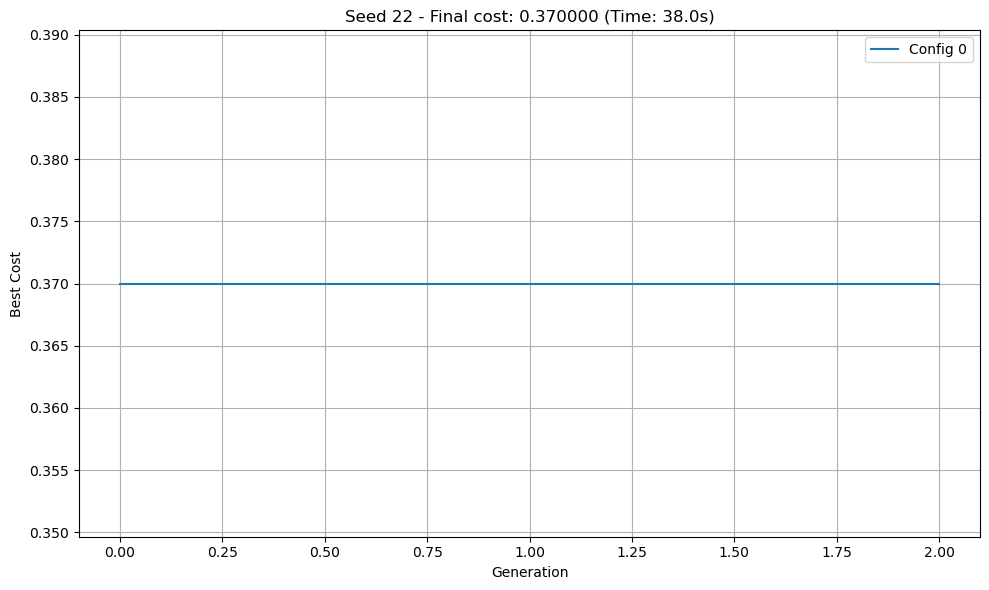

init LAP CUDA
Detected GPU compute capability: 8.9 (arch=sm_89)
GPU max threads per block: 1024
=== Compiling LAP kernels ===
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_89 -cubin /mnt/d//packing/temp/lap_batch_saved.cu -o /mnt/d//packing/temp/lap_batch.cubin
ptxas info    : 0 bytes gmem
ptxas info    : Compiling entry function 'diversity_shortcut_kernel' for 'sm_89'
ptxas info    : Function properties for diversity_shortcut_kernel
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 29 registers, used 1 barriers, 400 bytes cmem[0]
ptxas info    : Compile time = 9.515 ms
ptxas info    : Compiling entry function 'compute_costs' for 'sm_89'
ptxas info    : Function properties for compute_costs
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 29 registers, used 0 barriers, 384 bytes cmem[0]
ptxas info    : Compile time = 3.120 ms
ptxa

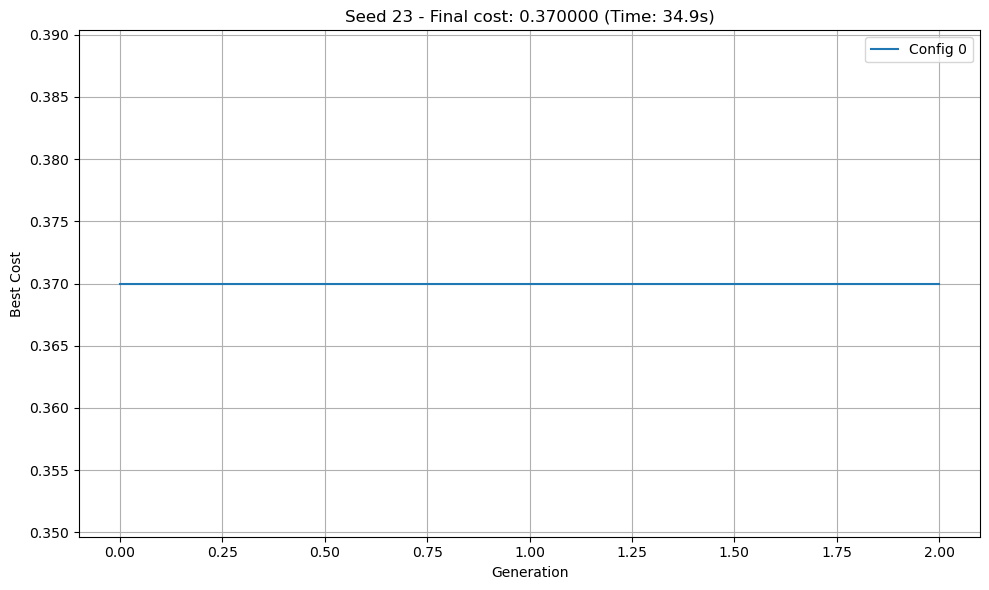

Starting process for seed 25...
local
Seed 24 using GPU 0

=== Starting seed 24 (Process 156429) ===
{'seed': 24, 'reset_approach': 2, 'reset_check_generations': 50, 'diversity_reset_threshold': -1.0, 'scale_rough_iterations': 1.0, 'scale_fine_iterations': 2.0, 'connectivity_pattern': 4, 'allow_reset_based_on_local_champion': True, 'prob_mate_own': 0.7, 'JiggleMaxTrees': 10, 'MoveRandomTree': False, 'JiggleTreeSmall': False, 'JiggleTreeBig': False, 'JiggleClusterSmall': False, 'JiggleClusterBig': False, 'Twist': True}
init CUDA
Detected GPU compute capability: 8.9 (arch=sm_89)
GPU max threads per block: 1024
=== Compiling kernel variant: crystal ===
Defines: ENABLE_CRYSTAL_AXES, ENABLE_OVERLAP_AREA, ENABLE_SEPARATION
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_89 -DENABLE_CRYSTAL_AXES -DENABLE_OVERLAP_AREA -DENABLE_SEPARATION -cubin /mnt/d//packing/temp/pack_cuda_saved.cu -o /mnt/d//packing/temp/pack_cud

/mnt/d/packing/code/analysis/../core/pack_dynamics.py:61: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/mnt/d/packing/code/analysis/../core/pack_dynamics.py:61: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/mnt/d/packing/code/analysis/../core/pack_dynamics.py:93: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_cost[:N].toDlpack()), from_dlpack(res.toDlpack())
/mnt/d/packing/code/analysis/../core/pack_dynamics.py:93: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_

init LAP CUDA
Detected GPU compute capability: 8.9 (arch=sm_89)
GPU max threads per block: 1024
=== Compiling LAP kernels ===
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_89 -cubin /mnt/d//packing/temp/lap_batch_saved.cu -o /mnt/d//packing/temp/lap_batch.cubin
ptxas info    : 0 bytes gmem
ptxas info    : Compiling entry function 'diversity_shortcut_kernel' for 'sm_89'
ptxas info    : Function properties for diversity_shortcut_kernel
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 29 registers, used 1 barriers, 400 bytes cmem[0]
ptxas info    : Compile time = 10.971 ms
ptxas info    : Compiling entry function 'compute_costs' for 'sm_89'
ptxas info    : Function properties for compute_costs
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 29 registers, used 0 barriers, 384 bytes cmem[0]
ptxas info    : Compile time = 2.974 ms
ptx

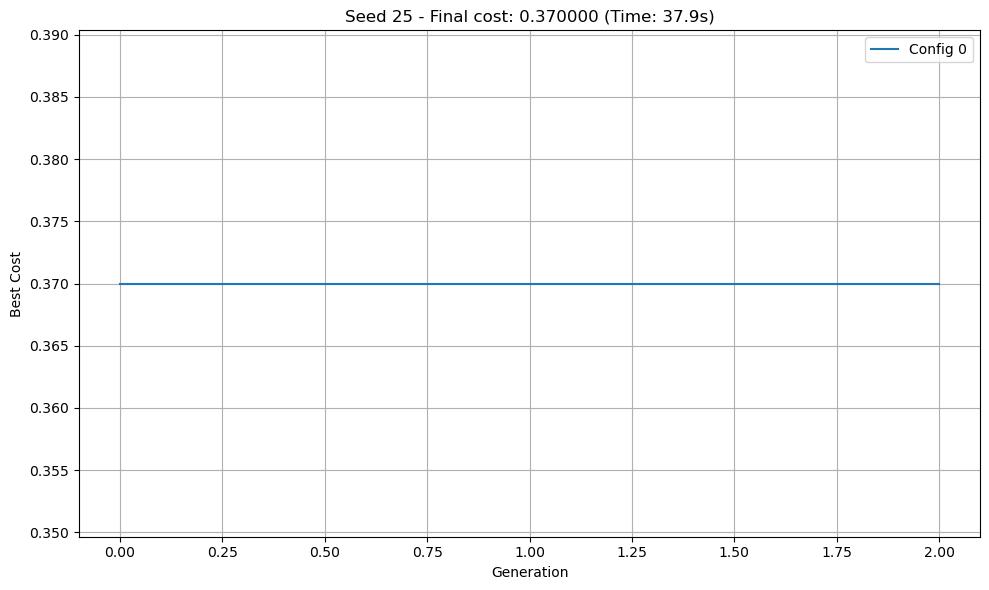

Generation 1: Best costs = [[0.37, 0.054058]]
Runtime: 43.4s

Seed 24 completed in 43.4s
Best final costs: [0.37]
Modifier values: {'seed': 24, 'reset_approach': 2, 'reset_check_generations': 50, 'diversity_reset_threshold': -1.0, 'scale_rough_iterations': 1.0, 'scale_fine_iterations': 2.0, 'connectivity_pattern': 4, 'allow_reset_based_on_local_champion': True, 'prob_mate_own': 0.7, 'JiggleMaxTrees': 10, 'MoveRandomTree': False, 'JiggleTreeSmall': False, 'JiggleTreeBig': False, 'JiggleClusterSmall': False, 'JiggleClusterBig': False, 'Twist': True}
Saved full: ../../results/many_ga/full/Baseline_24_bced8f09_fast_f.pkl
Saved abbr: ../../results/many_ga/abbr/Baseline_24_bced8f09_fast_a.pkl
Seed 24 finished successfully!

*** Result received for seed 24: avg_cost = 0.370000, time = 43.4s ***



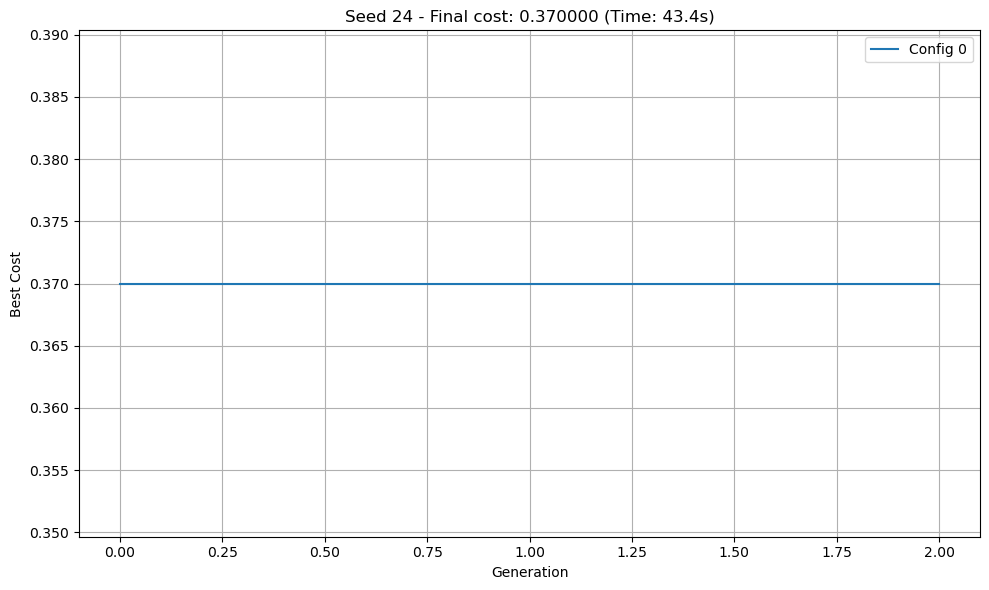

Starting process for seed 26...
Waiting 4.1s before starting seed 27...
local
Starting process for seed 27...
local
Seed 26 using GPU 0

=== Starting seed 26 (Process 156744) ===
{'seed': 26, 'reset_approach': 4, 'reset_check_generations': 50, 'diversity_reset_threshold': -1.0, 'scale_rough_iterations': 1.0, 'scale_fine_iterations': 1.0, 'connectivity_pattern': 1, 'allow_reset_based_on_local_champion': True, 'prob_mate_own': 0.7, 'JiggleMaxTrees': 20, 'MoveRandomTree': False, 'JiggleTreeSmall': True, 'JiggleTreeBig': False, 'JiggleClusterSmall': False, 'JiggleClusterBig': False, 'Twist': False}
init CUDA
Detected GPU compute capability: 8.9 (arch=sm_89)
GPU max threads per block: 1024
=== Compiling kernel variant: crystal ===
Defines: ENABLE_CRYSTAL_AXES, ENABLE_OVERLAP_AREA, ENABLE_SEPARATION
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_89 -DENABLE_CRYSTAL_AXES -DENABLE_OVERLAP_AREA -DENABLE_SEPARATION -

/mnt/d/packing/code/analysis/../core/pack_dynamics.py:61: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/mnt/d/packing/code/analysis/../core/pack_dynamics.py:93: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_cost[:N].toDlpack()), from_dlpack(res.toDlpack())
/mnt/d/packing/code/analysis/../core/pack_dynamics.py:61: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/mnt/d/packing/code/analysis/../core/pack_dynamics.py:93: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_

init LAP CUDA
Detected GPU compute capability: 8.9 (arch=sm_89)
GPU max threads per block: 1024
=== Compiling LAP kernels ===
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_89 -cubin /mnt/d//packing/temp/lap_batch_saved.cu -o /mnt/d//packing/temp/lap_batch.cubin
ptxas info    : 0 bytes gmem
ptxas info    : Compiling entry function 'diversity_shortcut_kernel' for 'sm_89'
ptxas info    : Function properties for diversity_shortcut_kernel
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 29 registers, used 1 barriers, 400 bytes cmem[0]
ptxas info    : Compile time = 9.772 ms
ptxas info    : Compiling entry function 'compute_costs' for 'sm_89'
ptxas info    : Function properties for compute_costs
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 29 registers, used 0 barriers, 384 bytes cmem[0]
ptxas info    : Compile time = 5.874 ms
ptxa

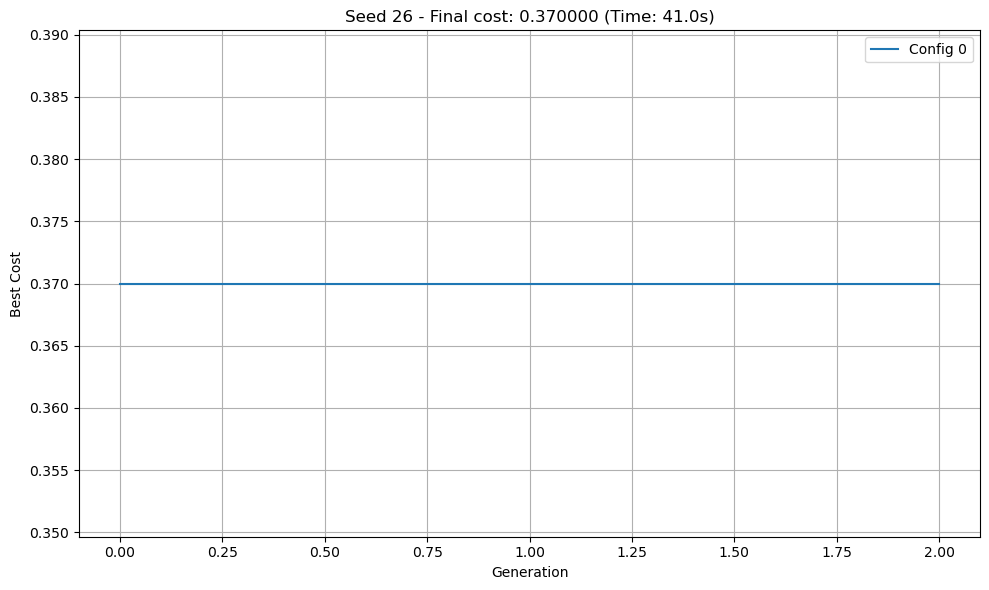

Generation 1: Best costs = [[0.37, 0.055238]]
Runtime: 39.6s

Seed 27 completed in 39.6s
Best final costs: [0.37]
Modifier values: {'seed': 27, 'reset_approach': 1, 'reset_check_generations': 100, 'diversity_reset_threshold': 0.00025, 'scale_rough_iterations': 1.0, 'scale_fine_iterations': 2.0, 'connectivity_pattern': 1, 'allow_reset_based_on_local_champion': False, 'prob_mate_own': 0.3, 'JiggleMaxTrees': 10, 'MoveRandomTree': False, 'JiggleTreeSmall': True, 'JiggleTreeBig': False, 'JiggleClusterSmall': False, 'JiggleClusterBig': True, 'Twist': False}
Saved full: ../../results/many_ga/full/Baseline_27_bced8f09_fast_f.pkl
Saved abbr: ../../results/many_ga/abbr/Baseline_27_bced8f09_fast_a.pkl
Seed 27 finished successfully!

*** Result received for seed 27: avg_cost = 0.370000, time = 39.6s ***



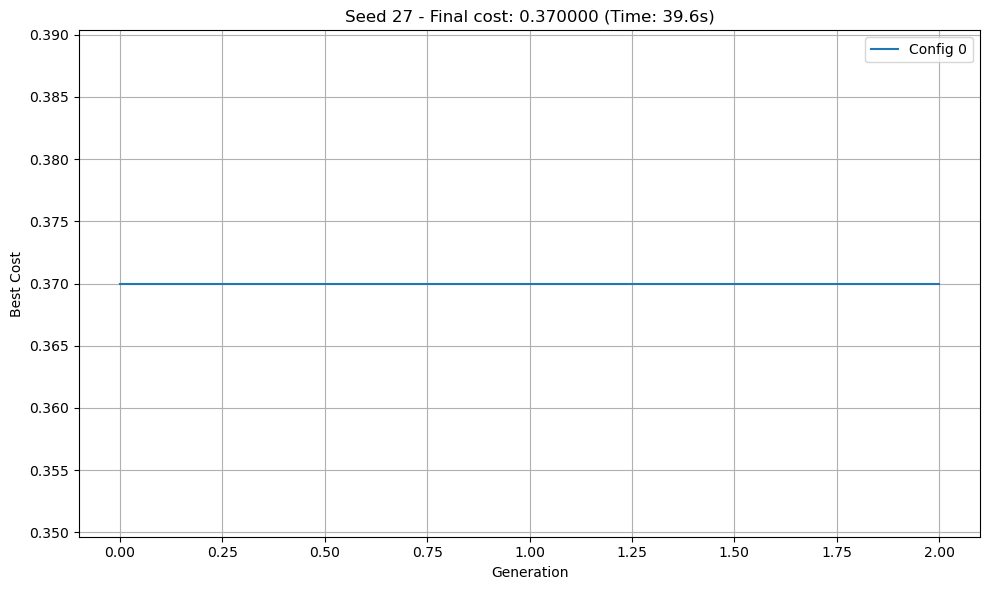

Starting process for seed 28...
Waiting 3.6s before starting seed 29...
local
Starting process for seed 29...
local
Seed 28 using GPU 0

=== Starting seed 28 (Process 157059) ===
{'seed': 28, 'reset_approach': 3, 'reset_check_generations': 100, 'diversity_reset_threshold': 0.00025, 'scale_rough_iterations': 2.0, 'scale_fine_iterations': 2.0, 'connectivity_pattern': 5, 'allow_reset_based_on_local_champion': False, 'prob_mate_own': 0.3, 'JiggleMaxTrees': 5, 'MoveRandomTree': True, 'JiggleTreeSmall': False, 'JiggleTreeBig': True, 'JiggleClusterSmall': True, 'JiggleClusterBig': False, 'Twist': True}
init CUDA
Detected GPU compute capability: 8.9 (arch=sm_89)
GPU max threads per block: 1024
=== Compiling kernel variant: crystal ===
Defines: ENABLE_CRYSTAL_AXES, ENABLE_OVERLAP_AREA, ENABLE_SEPARATION
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_89 -DENABLE_CRYSTAL_AXES -DENABLE_OVERLAP_AREA -DENABLE_SEPARATION 

/mnt/d/packing/code/analysis/../core/pack_dynamics.py:61: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/mnt/d/packing/code/analysis/../core/pack_dynamics.py:93: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_cost[:N].toDlpack()), from_dlpack(res.toDlpack())
/mnt/d/packing/code/analysis/../core/pack_dynamics.py:61: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/mnt/d/packing/code/analysis/../core/pack_dynamics.py:93: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_

init LAP CUDA
Detected GPU compute capability: 8.9 (arch=sm_89)
GPU max threads per block: 1024
=== Compiling LAP kernels ===
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_89 -cubin /mnt/d//packing/temp/lap_batch_saved.cu -o /mnt/d//packing/temp/lap_batch.cubin
ptxas info    : 0 bytes gmem
ptxas info    : Compiling entry function 'diversity_shortcut_kernel' for 'sm_89'
ptxas info    : Function properties for diversity_shortcut_kernel
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 29 registers, used 1 barriers, 400 bytes cmem[0]
ptxas info    : Compile time = 12.643 ms
ptxas info    : Compiling entry function 'compute_costs' for 'sm_89'
ptxas info    : Function properties for compute_costs
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 29 registers, used 0 barriers, 384 bytes cmem[0]
ptxas info    : Compile time = 2.940 ms
ptx

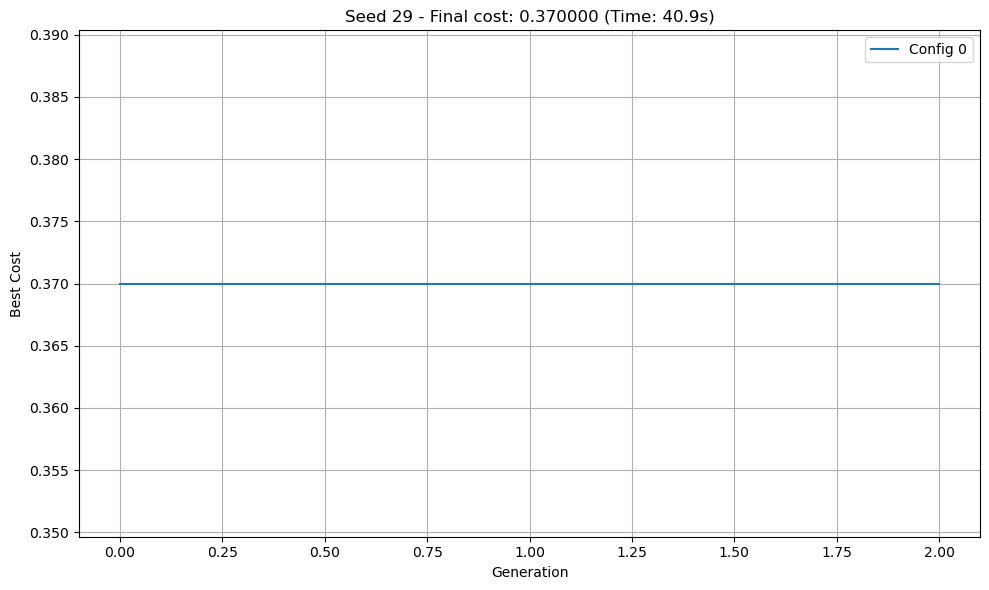

Generation 1: Best costs = [[0.37, 0.039974]]
Runtime: 46.1s

Seed 28 completed in 46.2s
Best final costs: [0.37]
Modifier values: {'seed': 28, 'reset_approach': 3, 'reset_check_generations': 100, 'diversity_reset_threshold': 0.00025, 'scale_rough_iterations': 2.0, 'scale_fine_iterations': 2.0, 'connectivity_pattern': 5, 'allow_reset_based_on_local_champion': False, 'prob_mate_own': 0.3, 'JiggleMaxTrees': 5, 'MoveRandomTree': True, 'JiggleTreeSmall': False, 'JiggleTreeBig': True, 'JiggleClusterSmall': True, 'JiggleClusterBig': False, 'Twist': True}
Saved full: ../../results/many_ga/full/Baseline_28_bced8f09_fast_f.pkl
Saved abbr: ../../results/many_ga/abbr/Baseline_28_bced8f09_fast_a.pkl
Seed 28 finished successfully!

*** Result received for seed 28: avg_cost = 0.370000, time = 46.2s ***



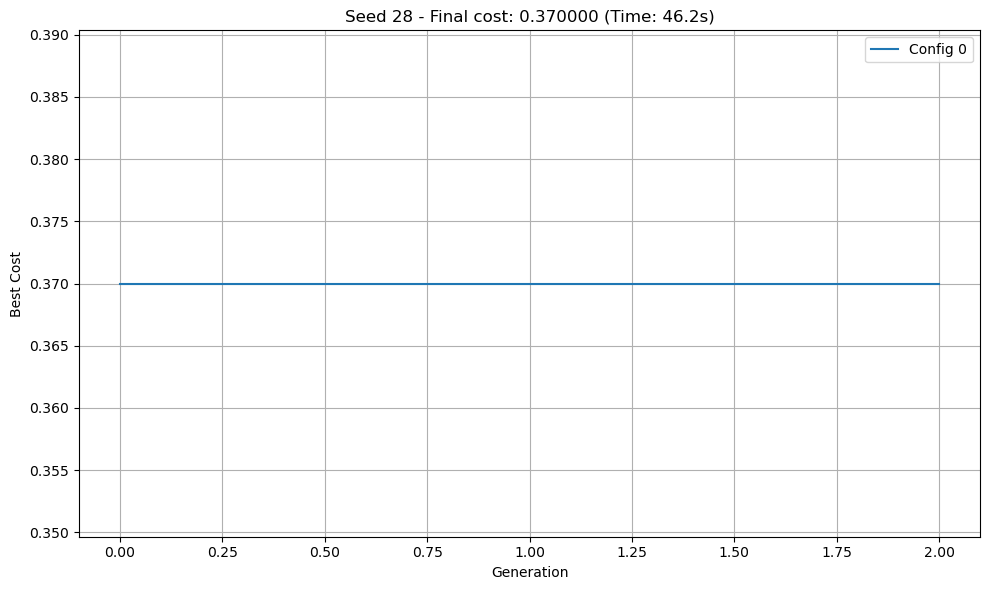


All 30 seeds completed!
Successful runs: 29
Failed runs: 1

Creating summary plots for 29 successful runs...


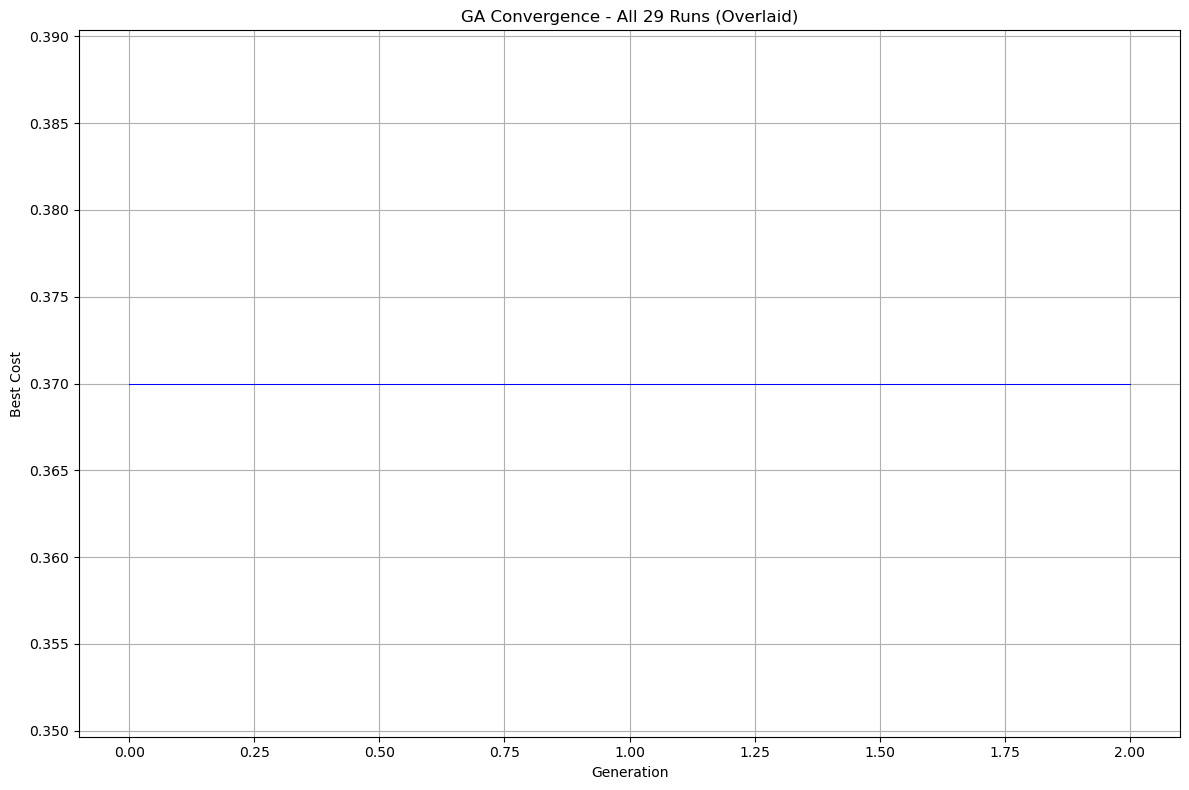

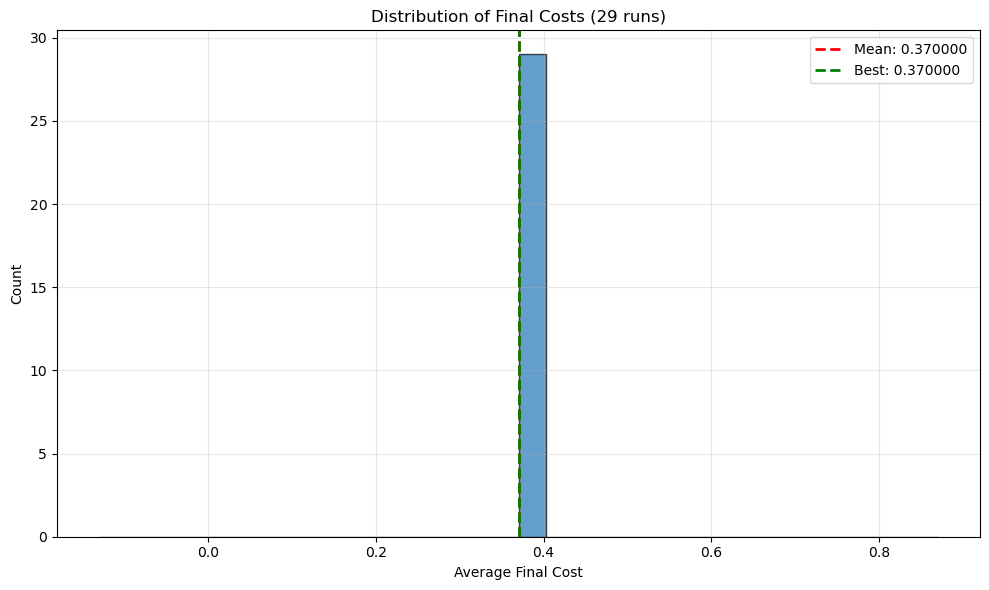


Final Statistics:
  Best cost:  0.370000
  Worst cost: 0.370000
  Mean cost:  0.370000
  Std cost:   0.000000
  Median cost: 0.370000


In [ ]:
import kaggle_support as kgs
kgs.profiling = False

def run_single_seed(seed, which_runner, fast_mode, git_commit_id, output_dir, result_queue):
    """Worker function to run a single seed in a separate process"""
    # Import everything needed in this worker process
    import sys
    sys.path.append('../core')
    sys.path.append('/packing/code/core/')
    
    import numpy as np
    import time
    import copy
    import os
    import dill
    
    try:
        # Set CUDA device based on process to avoid conflicts
        # This helps if you have multiple GPUs
        try:
            import cupy as cp
            # Use modulo to cycle through available GPUs
            n_gpus = cp.cuda.runtime.getDeviceCount()
            device_id = seed % n_gpus
            cp.cuda.Device(device_id).use()
            # Small delay to stagger CUDA initialization
            time.sleep(0.5)
            print(f'Seed {seed} using GPU {device_id}')
        except Exception as e:
            print(f'Warning: Could not set CUDA device for seed {seed}: {e}')
        
        print(f'\n=== Starting seed {seed} (Process {os.getpid()}) ===')
        
        r = which_runner(fast_mode=fast_mode)
        r.seed = seed
        r.base_ga.ga.ga_base.N_trees_to_do = 68
        
        # Check if this experiment already exists
        base_filename = f"{r.label}_{r.seed}_{git_commit_id[:8]}"
        if fast_mode:
            base_filename += '_fast'
        
        # Run the experiment
        start_time = time.time()
        r.run()
        elapsed_time = time.time() - start_time
        
        if r.exception is not None:
            print(f"ERROR occurred in seed {seed}: {r.exception[:200]}")
            result_queue.put({'seed': seed, 'success': False, 'error': r.exception[:200]})
            return
        
        # Get best costs for each configuration (tree sizes, etc.)
        # r.best_costs is now shape (n_generations, n_configs) from pack_ga2 structure
        best_costs_final = r.best_costs[-1, :]
        print(f"\nSeed {seed} completed in {elapsed_time:.1f}s")
        print(f"Best final costs: {best_costs_final}")
        print(f"Modifier values: {r.modifier_values}")
        
        # Create score string from average best cost
        avg_cost = np.mean(best_costs_final)
        score_str = f"{avg_cost:.4f}".replace('.', '_')
        
        # Save full version (with populations)
        output_file_full = output_dir + 'full/' + base_filename + '_f.pkl'
        with open(output_file_full, 'wb') as f:
            dill.dump(r, f)
        print(f"Saved full: {output_file_full}")
        
        # Save abbreviated version (without populations to save space)
        r_abbr = copy.deepcopy(r)
        #r_abbr.result_ga.ga.champions = []  # Clear champions to save space
        r_abbr.result_ga.ga.abbreviate()
        output_file_abbr = output_dir + 'abbr/' + base_filename + '_a.pkl'
        with open(output_file_abbr, 'wb') as f:
            dill.dump(r_abbr, f)
        print(f"Saved abbr: {output_file_abbr}")
        
        # Put result data in queue for plotting
        result_queue.put({
            'seed': seed,
            'success': True,
            'label': r.label,
            'best_costs': r.best_costs.copy(),
            'n_configs': r.best_costs.shape[1],  # Number of configurations (tree sizes, etc.)
            'avg_cost': avg_cost,
            'elapsed_time': elapsed_time
        })
        
        print(f"Seed {seed} finished successfully!")
        print(f"{'='*60}")
        
    except Exception as e:
        import traceback
        error_msg = traceback.format_exc()
        print(f"EXCEPTION in seed {seed}:\n{error_msg}")
        result_queue.put({'seed': seed, 'success': False, 'error': str(e)})


# Main parallel execution
n_seeds = 1000 if not fast_mode else 30
result_queue = Queue()
active_processes = []
completed_results = []
seeds_to_run = [a+0 for a in list(range(n_seeds))]
next_seed_idx = 0

# Limit parallel processes if using GPU (to avoid memory issues)
# You may want to adjust this based on your GPU memory
import cupy as cp
n_gpus = cp.cuda.runtime.getDeviceCount()
print(f"Detected {n_gpus} GPU(s)")

# Adjust parallel processes - too many can overwhelm GPU memory
# Start with 1-2 processes per GPU, adjust based on your GPU memory
max_parallel = n_parallel_processes
print(f"Starting parallel execution of {n_seeds} seeds using {max_parallel} processes")
print(f"Staggering process startup by 2 seconds each...\n")

# Start initial batch of processes with staggered startup
stagger_delay = 30.0  # seconds between each process start
for i in range(min(max_parallel, n_seeds)):
    seed = seeds_to_run[next_seed_idx]
    print(f"Starting process for seed {seed}...")
    p = Process(target=run_single_seed, args=(seed, which_runner, fast_mode, git_commit_id, output_dir, result_queue))
    p.start()
    active_processes.append((p, seed))
    next_seed_idx += 1
    
    # Stagger the startup to avoid CUDA initialization conflicts
    if i < min(max_parallel, n_seeds) - 1:  # Don't sleep after the last one
        time.sleep(stagger_delay)

print(f"\nAll initial processes started. Monitoring for completion...\n")

# Track when we last started a process to stagger new starts
last_process_start_time = time.time()

# Main loop: wait for processes to complete and start new ones
while active_processes or not result_queue.empty():
    # Check for completed results in queue
    while not result_queue.empty():
        result = result_queue.get()
        completed_results.append(result)
        
        if result['success']:
            print(f"\n*** Result received for seed {result['seed']}: avg_cost = {result['avg_cost']:.6f}, time = {result['elapsed_time']:.1f}s ***\n")
            
            # Plot convergence for this seed immediately
            fig, ax = plt.subplots(figsize=(10, 6))
            for i_config in range(result['n_configs']):
                ax.plot(result['best_costs'][:, i_config], label=f'Config {i_config}')
            ax.set_xlabel('Generation')
            ax.set_ylabel('Best Cost')
            ax.set_title(f"Seed {result['seed']} - Final cost: {result['avg_cost']:.6f} (Time: {result['elapsed_time']:.1f}s)")
            ax.legend()
            ax.grid(True)
            plt.tight_layout()
            plt.show()
            
        else:
            print(f"\n*** Seed {result['seed']} failed: {result.get('error', 'Unknown error')} ***\n")
    
    # Check for finished processes and start new ones
    for i in range(len(active_processes) - 1, -1, -1):
        p, seed = active_processes[i]
        if not p.is_alive():
            p.join()
            active_processes.pop(i)
            
            # Start a new process if there are more seeds to run
            if next_seed_idx < n_seeds:
                new_seed = seeds_to_run[next_seed_idx]
                
                # Stagger new process starts to avoid CUDA conflicts
                time_since_last_start = time.time() - last_process_start_time
                if time_since_last_start < stagger_delay:
                    sleep_time = stagger_delay - time_since_last_start
                    print(f"Waiting {sleep_time:.1f}s before starting seed {new_seed}...")
                    time.sleep(sleep_time)
                
                print(f"Starting process for seed {new_seed}...")
                new_p = Process(target=run_single_seed, args=(new_seed, which_runner, fast_mode, git_commit_id, output_dir, result_queue))
                new_p.start()
                active_processes.append((new_p, new_seed))
                last_process_start_time = time.time()
                next_seed_idx += 1
    
    # Small sleep to avoid busy waiting
    time.sleep(0.1)

print(f"\n{'='*80}")
print(f"All {n_seeds} seeds completed!")
print(f"Successful runs: {sum(1 for r in completed_results if r['success'])}")
print(f"Failed runs: {sum(1 for r in completed_results if not r['success'])}")

# Create summary plots for all successful runs
successful_results = [r for r in completed_results if r['success']]
if successful_results:
    print(f"\nCreating summary plots for {len(successful_results)} successful runs...")
    
    # Plot all convergence curves overlaid
    fig, ax = plt.subplots(figsize=(12, 8))
    for result in successful_results:
        for i_config in range(result['n_configs']):
            ax.plot(result['best_costs'][:, i_config], alpha=0.3, linewidth=0.5, color='blue')
    
    ax.set_xlabel('Generation')
    ax.set_ylabel('Best Cost')
    ax.set_title(f'GA Convergence - All {len(successful_results)} Runs (Overlaid)')
    ax.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Plot distribution of final costs
    final_costs = [r['avg_cost'] for r in successful_results]
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.hist(final_costs, bins=30, edgecolor='black', alpha=0.7)
    ax.axvline(np.mean(final_costs), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(final_costs):.6f}')
    ax.axvline(np.min(final_costs), color='green', linestyle='--', linewidth=2, label=f'Best: {np.min(final_costs):.6f}')
    ax.set_xlabel('Average Final Cost')
    ax.set_ylabel('Count')
    ax.set_title(f'Distribution of Final Costs ({len(successful_results)} runs)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"\nFinal Statistics:")
    print(f"  Best cost:  {np.min(final_costs):.6f}")
    print(f"  Worst cost: {np.max(final_costs):.6f}")
    print(f"  Mean cost:  {np.mean(final_costs):.6f}")
    print(f"  Std cost:   {np.std(final_costs):.6f}")
    print(f"  Median cost: {np.median(final_costs):.6f}")


Found 29 result files

Successfully completed runs: 29
Best average cost: 0.370000
Worst average cost: 0.370000
Mean average cost: 0.370000
Std average cost: 0.000000


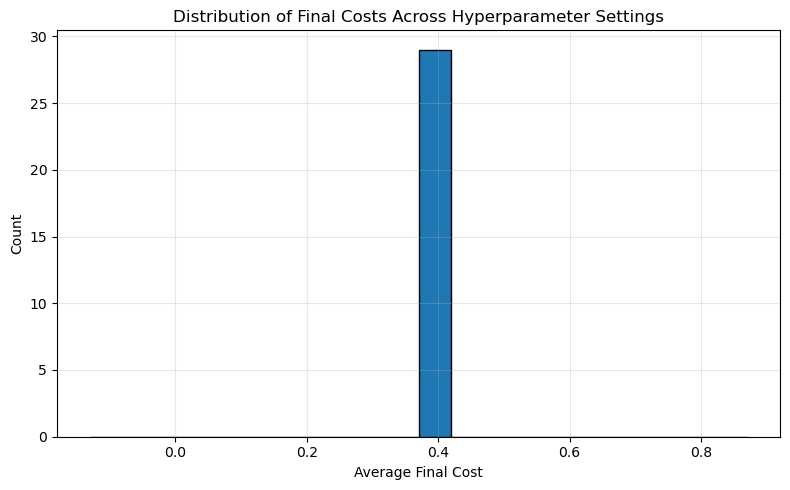

In [6]:
# Optional: Load and analyze results
results_files = sorted(glob.glob(output_dir + 'abbr/*.pkl'))
print(f"Found {len(results_files)} result files")

if len(results_files) > 0:
    # Load all results
    results = []
    for f in results_files:
        with open(f, 'rb') as fp:
            results.append(dill.load(fp))
    
    # Extract hyperparameters and final costs
    hyperparams = []
    final_costs = []
    
    for r in results:
        if r.exception is None and r.best_costs is not None:
            hyperparams.append(r.modifier_values)
            # r.best_costs is shape (n_generations, n_configs)
            # Average across all configs for overall score
            final_costs.append(np.mean(r.best_costs[-1, :]))
    
    print(f"\nSuccessfully completed runs: {len(final_costs)}")
    if len(final_costs) > 0:
        print(f"Best average cost: {np.min(final_costs):.6f}")
        print(f"Worst average cost: {np.max(final_costs):.6f}")
        print(f"Mean average cost: {np.mean(final_costs):.6f}")
        print(f"Std average cost: {np.std(final_costs):.6f}")
        
        # Plot distribution of final costs
        plt.figure(figsize=(8, 5))
        plt.hist(final_costs, bins=20, edgecolor='black')
        plt.xlabel('Average Final Cost')
        plt.ylabel('Count')
        plt.title('Distribution of Final Costs Across Hyperparameter Settings')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
